The goal of this notebook is to assess if larger protein family size perform better compared to smaller ones

## Setup

In [1]:
#import dependencies
import os.path
#os.chdir("set working path here")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers.models.esm.modeling_esm import EsmPreTrainedModel, EsmModel
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer, set_seed
from transformers import DataCollatorForTokenClassification

from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Union

# for custom DataCollator
from transformers.data.data_collator import DataCollatorMixin
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.utils import PaddingStrategy

import peft
from peft import get_peft_config, PeftModel, PeftConfig, inject_adapter_in_model, LoraConfig

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

# Environment to run this notebook


These are the versions of the core packages we use to run this notebook:

In [2]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.5.1+cu124
Cuda version:  12.4
Numpy version:  2.0.2
Pandas version:  2.2.3
Transformers version:  4.51.3
Datasets version:  3.1.0


# Valid Model checkpoints

This notebook was tested with all models mentioned below.
All required, model specific adaptations will be taken care of.

In [3]:
ESMs = ["facebook/esm2_t6_8M_UR50D",
         "facebook/esm2_t12_35M_UR50D",
         "facebook/esm2_t30_150M_UR50D",
         "facebook/esm2_t33_650M_UR50D",
         "facebook/esm2_t36_3B_UR50D"]

ProtT5 = ["Rostlab/prot_t5_xl_uniref50"]

# Input data

Provide your training and validation data in seperate pandas dataframes 

example shown below

**Modify the data loading part above as needed for your data**

To run the training you need two dataframes (training and validation) each with the columns "sequence" and "label" and "mask"

Columns are:
+ protein sequence
+ label is a list of len(protein sequence) with integers (from 0 to number of classes - 1) corresponding to predicted class at this position
+ mask gives the possibility to ignore parts of the positions. Provide a list of len(protein sequence) where 1 is processed, while 0 is ignored

In [4]:
all_features = ['Active site', 'Binding site', 'DNA binding', 
                'Topological domain', 'Transmembrane',
                'Disulfide bond', 'Modified residue', 'Propeptide', 'Signal peptide', 'Transit peptide',
                'Beta strand', 'Helix', 'Turn',
                'Coiled coil', 'Compositional bias', 'Domain [FT]', 'Motif', 'Region', 'Repeat', 'Zinc finger']

all_features_re = ['ACT_SITE', 'BINDING', 'DNA_BIND', 
                   'TOPO_DOM', 'TRANSMEM',
                   'DISULFID', 'MOD_RES',  'PROPEP', 'SIGNAL', 'TRANSIT',
                   'STRAND', 'HELIX', 'TURN',
                   'COILED', 'COMPBIAS', 'DOMAIN', 'MOTIF', 'REGION', 'REPEAT', 'ZN_FING']

In [5]:
def build_labels_region(sequence, feature, feature_re):
    # Start with all 0s
    labels = np.zeros(len(sequence), dtype=np.int64)
    region_re = f"{feature_re}\s(\d+)\.\.(\d+)\;"
    residue_re = f'{feature_re}\s(\d+);'

    found_region = re.findall(region_re, feature)

    for start, end in found_region:
        start = int(start) - 1
        end = int(end)
        assert end <= len(sequence)
        labels[start: end] = 1

    found_residue = re.findall(residue_re, feature)
    for pos in found_residue:
        pos = int(pos) -1
        assert pos <= len(sequence)
        labels[pos] = 1

    return labels


def build_labels_bonds(sequence, feature, feature_re):
    # Start with all 0s
    labels = np.zeros(len(sequence), dtype=np.int64)

    region_re = f"{feature_re}\s(\d+)\.\.(\d+)\;"

    if isinstance(feature, float): # Indicates missing (NaN)
        found_feature = []
    else:
        found_feature = re.findall(region_re, feature)
    for start, end in found_feature:
        start = int(start) - 1
        end = int(end) -1
        assert end <= len(sequence)
        labels[start] = 1
        labels[end] = 1 
    return labels


In [6]:
def create_train_test_val_df(feature_name, feature_name_re):
        
    #read_train_test_val embeds
    train_df = pd.read_csv(f"/work/gr-fe/saadat/pLM_finetune/ESM2-Missense-Impact-Analysis/data/splits/df/{feature_name}_train.tsv.gz", sep='\t')[['Sequence', 'Protein families' , 'cluster_id',feature_name]]
    val_df = pd.read_csv(f"/work/gr-fe/saadat/pLM_finetune/ESM2-Missense-Impact-Analysis/data/splits/df/{feature_name}_val.tsv.gz", sep='\t')[['Sequence', 'Protein families' , 'cluster_id', feature_name]]
    test_df = pd.read_csv(f"/work/gr-fe/saadat/pLM_finetune/ESM2-Missense-Impact-Analysis/data/splits/df/{feature_name}_test.tsv.gz", sep='\t')[['Sequence', 'Protein families' , 'cluster_id', feature_name]]

    # create labels
    if feature_name == 'Disulfide bond':
        labeler_func = build_labels_bonds
    else:
        labeler_func = build_labels_region

    train_df['Label'] = None
    for row_idx, row in train_df.iterrows():
        row_labels = labeler_func(row["Sequence"], row[feature_name], feature_name_re)
        train_df.at[row_idx, 'Label']= row_labels
    train_df.columns = train_df.columns.str.lower()
    
    test_df['Label'] = None
    for row_idx, row in test_df.iterrows():
        row_labels = labeler_func(row["Sequence"], row[feature_name], feature_name_re)
        test_df.at[row_idx, 'Label']= row_labels
    test_df.columns = test_df.columns.str.lower()
    
    val_df['Label'] = None
    for row_idx, row in val_df.iterrows():
        row_labels = labeler_func(row["Sequence"], row[feature_name], feature_name_re)
        val_df.at[row_idx, 'Label']= row_labels
    val_df.columns = val_df.columns.str.lower()
    
    return train_df[['sequence', 'protein families', 'cluster_id', 'label']], test_df[['sequence', 'protein families', 'cluster_id', 'label']], val_df[['sequence', 'protein families' , 'cluster_id', 'label']]


    

# Models and Low Rank Adaptation

## ESM2 Models

### Classification model definition and DataCollator

In [7]:
class EsmForTokenClassificationCustom(EsmPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.esm = EsmModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, TokenClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the token classification loss. Indices should be in `[0, ..., config.num_labels - 1]`.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.esm(
            input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        # changed to ignore special tokens at the seq start and end 
        # as well as invalid positions (labels -100)
        if labels is not None:
            loss_fct = CrossEntropyLoss()

            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, self.num_labels)

            active_labels = torch.where(
              active_loss, labels.view(-1), torch.tensor(-100).type_as(labels)
            )

            valid_logits=active_logits[active_labels!=-100]
            valid_labels=active_labels[active_labels!=-100]
            
            valid_labels=valid_labels.type(torch.LongTensor).to('cuda:0')
            
            loss = loss_fct(valid_logits, valid_labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

    
# based on transformers DataCollatorForTokenClassification
@dataclass
class DataCollatorForTokenClassificationESM(DataCollatorMixin):
    """
    Data collator that will dynamically pad the inputs received, as well as the labels.
    Args:
        tokenizer ([`PreTrainedTokenizer`] or [`PreTrainedTokenizerFast`]):
            The tokenizer used for encoding the data.
        padding (`bool`, `str` or [`~utils.PaddingStrategy`], *optional*, defaults to `True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            - `True` or `'longest'` (default): Pad to the longest sequence in the batch (or no padding if only a single
              sequence is provided).
            - `'max_length'`: Pad to a maximum length specified with the argument `max_length` or to the maximum
              acceptable input length for the model if that argument is not provided.
            - `False` or `'do_not_pad'`: No padding (i.e., can output a batch with sequences of different lengths).
        max_length (`int`, *optional*):
            Maximum length of the returned list and optionally padding length (see above).
        pad_to_multiple_of (`int`, *optional*):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
        label_pad_token_id (`int`, *optional*, defaults to -100):
            The id to use when padding the labels (-100 will be automatically ignore by PyTorch loss functions).
        return_tensors (`str`):
            The type of Tensor to return. Allowable values are "np", "pt" and "tf".
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    label_pad_token_id: int = -100
    return_tensors: str = "pt"

    def torch_call(self, features):
        import torch

        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature[label_name] for feature in features] if label_name in features[0].keys() else None

        no_labels_features = [{k: v for k, v in feature.items() if k != label_name} for feature in features]

        batch = self.tokenizer.pad(
            no_labels_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        if labels is None:
            return batch

        sequence_length = batch["input_ids"].shape[1]
        padding_side = self.tokenizer.padding_side

        def to_list(tensor_or_iterable):
            if isinstance(tensor_or_iterable, torch.Tensor):
                return tensor_or_iterable.tolist()
            return list(tensor_or_iterable)

        if padding_side == "right":
            batch[label_name] = [
                # to_list(label) + [self.label_pad_token_id] * (sequence_length - len(label)) for label in labels
                # changed to pad the special tokens at the beginning and end of the sequence
                [self.label_pad_token_id] + to_list(label) + [self.label_pad_token_id] * (sequence_length - len(label)-1) for label in labels
            ]
        else:
            batch[label_name] = [
                [self.label_pad_token_id] * (sequence_length - len(label)) + to_list(label) for label in labels
            ]

        batch[label_name] = torch.tensor(batch[label_name], dtype=torch.float)
        return batch

def _torch_collate_batch(examples, tokenizer, pad_to_multiple_of: Optional[int] = None):
    """Collate `examples` into a batch, using the information in `tokenizer` for padding if necessary."""
    import torch

    # Tensorize if necessary.
    if isinstance(examples[0], (list, tuple, np.ndarray)):
        examples = [torch.tensor(e, dtype=torch.long) for e in examples]

    length_of_first = examples[0].size(0)

    # Check if padding is necessary.

    are_tensors_same_length = all(x.size(0) == length_of_first for x in examples)
    if are_tensors_same_length and (pad_to_multiple_of is None or length_of_first % pad_to_multiple_of == 0):
        return torch.stack(examples, dim=0)

    # If yes, check if we have a `pad_token`.
    if tokenizer._pad_token is None:
        raise ValueError(
            "You are attempting to pad samples but the tokenizer you are using"
            f" ({tokenizer.__class__.__name__}) does not have a pad token."
        )

    # Creating the full tensor and filling it with our data.
    max_length = max(x.size(0) for x in examples)
    if pad_to_multiple_of is not None and (max_length % pad_to_multiple_of != 0):
        max_length = ((max_length // pad_to_multiple_of) + 1) * pad_to_multiple_of
    result = examples[0].new_full([len(examples), max_length], tokenizer.pad_token_id)
    for i, example in enumerate(examples):
        if tokenizer.padding_side == "right":
            result[i, : example.shape[0]] = example
        else:
            result[i, -example.shape[0] :] = example
    return result

def tolist(x):
    if isinstance(x, list):
        return x
    elif hasattr(x, "numpy"):  # Checks for TF tensors without needing the import
        x = x.numpy()
    return x.tolist()


### Load ESM2 Model

In [8]:
#load ESM2 models
def load_esm_model_classification(checkpoint, num_labels, half_precision, full=False, deepspeed=False):
    
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    
    if half_precision and deepspeed:
        model = EsmForTokenClassificationCustom.from_pretrained(checkpoint, num_labels = num_labels, torch_dtype = torch.float16)
    else:
        model = EsmForTokenClassificationCustom.from_pretrained(checkpoint, num_labels = num_labels)
        
    if full == True:
        return model, tokenizer 
        
    peft_config = LoraConfig(
        r=4, lora_alpha=1, bias="all", target_modules=["query","key","value","dense"]
    )
    
    model = inject_adapter_in_model(peft_config, model)
    
    # Unfreeze the prediction head
    for (param_name, param) in model.classifier.named_parameters():
                param.requires_grad = True  
    
    return model, tokenizer

# Training Definition 

## Deepspeed config

In [9]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

# Load function for finetuned model

In [10]:
def load_model(checkpoint, filepath, num_labels=2, mixed = True, full = False, deepspeed=False):
# Creates a new PT5 model and loads the finetuned weights from a file
#example: tokenizer, model_reload = load_model(checkpoint, f"./fine_tuned_models/{checkpoint}/{all_features_re[0]}.pth", num_labels=2)
    
    # load model
    if "esm" in checkpoint:
        model, tokenizer = load_esm_model_classification(checkpoint, num_labels, mixed, full, deepspeed)
    else:
        model, tokenizer = load_T5_model_classification(checkpoint, num_labels, mixed, full, deepspeed)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

# Evaluate on a test set

In [11]:
# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

# Dataset creation
def create_dataset(tokenizer,seqs,labels,checkpoint):
    
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    
    if ("esm" in checkpoint):
        # we need to cut of labels after 1022 positions for the data collator to add the correct padding (1022 + 2 special tokens)
        labels = [l[:1022] for l in labels]       
    else:
        # we need to cut of labels after 1023 positions for the data collator to add the correct padding (1023 + 1 special tokens)
        labels = [l[:1023] for l in labels] 
        
    dataset = dataset.add_column("labels", labels)
     
    return dataset

In [12]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    matthews_corrcoef, roc_auc_score)

def evaluate_on_test(model, tokenizer, test_df, checkpoint, metric_path):
    
    # Preprocess sequences
    test_df["sequence"]=test_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    if "prot_t5" in checkpoint:
        test_df['sequence']=test_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
    
    # Set the device to use
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    # Create Dataset
    test_set=create_dataset(tokenizer,list(test_df['sequence']),list(test_df['label']),checkpoint)
    
    # Make compatible with torch DataLoader
    test_set = test_set.with_format("torch", device=device)
    
    # For token classification we need a data collator here to pad correctly
    if ("esm" in checkpoint):
        data_collator = DataCollatorForTokenClassificationESM(tokenizer) 
    # For Ankh and ProtT5 pad only at the end
    else:
        data_collator = DataCollatorForTokenClassification(tokenizer)  
    
    # Create a dataloader for the test dataset
    test_dataloader = DataLoader(test_set, batch_size=16, shuffle = False, collate_fn = data_collator)
    
    # Put the model in evaluation mode
    model.eval()
    
    predictions = []
    probabilities = []
    padded_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
    
            logits = model(input_ids, attention_mask=attention_mask).logits  # shape: (batch_size, seq_len, num_classes)
            probs = torch.softmax(logits, dim=-1)
            preds = probs.argmax(dim=-1)
    
            # Save per-token predictions and labels
            predictions.extend(preds.cpu().tolist())           # shape: (batch_size, seq_len)
            probabilities.extend(probs[:, :, 1].cpu().tolist()) # shape: (batch_size, seq_len), prob for class 1
            padded_labels.extend(labels.tolist())
    
    # Flatten all to 1D arrays
    predictions = np.array([p for seq in predictions for p in seq])
    probabilities = np.array([p for seq in probabilities for p in seq])
    padded_labels = np.array([l for seq in padded_labels for l in seq])
    
    # Filter out masked (-100) labels
    mask = padded_labels != -100
    y_true = padded_labels[mask]
    y_pred = predictions[mask]
    y_prob = probabilities[mask]
    
    # Compute metrics
    metrics = {}
    
    try:
        metrics["f1"] = f1_score(y_true, y_pred, average='macro')
    except Exception:
        metrics["f1"] = np.nan
    
    try:
        metrics["precision"] = precision_score(y_true, y_pred, average='macro')
    except Exception:
        metrics["precision"] = np.nan
    
    try:
        metrics["recall"] = recall_score(y_true, y_pred, average='macro')
    except Exception:
        metrics["recall"] = np.nan
    
    try:
        metrics["mcc"] = matthews_corrcoef(y_true, y_pred)
    except Exception:
        metrics["mcc"] = np.nan
    
    try:
        metrics["auroc"] = roc_auc_score(y_true, y_prob)
    except Exception:
        metrics["auroc"] = np.nan
    
    try:
        metrics["accuracy"] = accuracy_score(y_true, y_pred)
    except Exception:
        metrics["accuracy"] = np.nan

    # Save to TSV
    df_metrics = pd.DataFrame([metrics])
    df_metrics.to_csv(metric_path, sep="\t", index=False)
    print(f"Test metrics saved to {metric_path}")

    return model, metrics

### Training and testing

In [13]:
selected_checkpoint = "facebook/esm2_t36_3B_UR50D"

In [14]:
for i in range(len(all_features)):

    print(f'i = {i}')
    _, test_df, _ = create_train_test_val_df(feature_name=all_features[i], feature_name_re=all_features_re[i])
    
    colname = all_features[i]
    feature_re = all_features_re[i]
    
    # Load model
    finetuned_params_path = f'../res/models/ft_{feature_re}_{selected_checkpoint.split("/")[1]}.pth'
    tokenizer, model = load_model(selected_checkpoint, finetuned_params_path)
    
    family_col = 'protein families'
    
    # Loop over each protein family in the test set
    for prot_family in test_df[family_col].unique():
        
        # Subset test set for the current protein family
        test_subset = test_df[test_df[family_col] == prot_family].copy()
        
        # Skip empty or tiny subsets
        if len(test_subset) < 1:
            continue
        
        # Run evaluation and save metrics
        metric_path = f"../res/metrics_per_family/ft_{feature_re}_{selected_checkpoint.split('/')[1]}_{prot_family.replace('/', '_')}_len{len(test_subset)}.tsv.gz"
        evaluate_on_test(model, tokenizer, test_subset, checkpoint=selected_checkpoint, metric_path=metric_path)


i = 0


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_GART family; Aldehyde dehydrogenase family, ALDH1L subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Aldehyde dehydrogenase family_len10.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase C12 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase C12 family, BAP1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Diacylglycerol acyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Selenophosphate synthase 1 family, Class II subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.38it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Selenophosphate synthase 1 family, Class I subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Carbon-nitrogen hydrolase superfamily, BUP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Class-V pyridoxal-phosphate-dependent aminotransferase family, MOCOS subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Glycosyl hydrolase 2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Ribonucleoside diphosphate reductase small chain family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Glycosyltransferase 10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Glycosyl hydrolase 31 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_LDH_MDH superfamily, LDH family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase A2 family, HERV class-II K(HML-2) subfamily_len12.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Argonaute family, Piwi subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_PA-PLA1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase M14 family_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase C65 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Neutral sphingomyelinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.63it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Glycosyltransferase 68 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Ubiquitin-conjugating enzyme family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_ArsA ATPase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Cation transport ATPase (P-type) (TC 3.A.3) family, Type IIA subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Cation transport ATPase (P-type) (TC 3.A.3) family, Type IIC subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.68it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Transaldolase family, Type 1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_AB hydrolase superfamily, Lipase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Copper_topaquinone oxidase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Protein kinase superfamily, TKL Ser_Thr protein kinase family, MAP kinase kinase kinase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_DHHC palmitoyltransferase family, AKR_ZDHHC17 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_DHHC palmitoyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_UDP-glucose_GDP-mannose dehydrogenase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_ADAT1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Phosphoenolpyruvate carboxykinase [GTP] family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Dus family, Dus3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.03it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Dus family, Dus2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Dus family, Dus4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Dus family, Dus1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_DeoC_FbaB aldolase family, DeoC type 2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_ARB2A family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Thioesterase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_LipB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Oligoribonuclease family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_AB hydrolase superfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase T1B family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Mannose-6-phosphate isomerase type 1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Class-V pyridoxal-phosphate-dependent aminotransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Class-V pyridoxal-phosphate-dependent aminotransferase family, NifS_IscS subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Uracil-DNA glycosylase (UDG) superfamily, UNG family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_NAD-dependent glycerol-3-phosphate dehydrogenase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Schlafen family, Subgroup III subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Class-II pyridoxal-phosphate-dependent aminotransferase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Protein sulfotransferase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.65it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Acetyltransferase family, NAA60 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Phosphoglycerate mutase family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase S16 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.45s/it]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Protein kinase superfamily, STE Ser_Thr protein kinase family, STE20 subfamily_len18.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Pancreatic ribonuclease family_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_CoA-transferase III family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_CMP-NeuNAc synthase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Glycosyltransferase 47 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Pyridoxine kinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Glycosyl hydrolase 47 family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase M16 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Enolase family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Helicase family, RecQ subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Phospholipase A2 family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Glu_Leu_Phe_Val dehydrogenases family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.81it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Calycin superfamily, Lipocalin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_AAA ATPase family; Peptidase M41 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.06s/it]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase C19 family_len14.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase C19 family, USP12_USP46 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase C19 family, USP2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase C19 family, USP14_UBP6 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.21s/it]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase C19 family, USP17 subfamily_len17.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase C19 family, USP10 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase C19 family, USP20_USP33 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase C19 family, USP44 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase C19 family, USP21 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase C19 family, UBP8 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase C19 family, USP16 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase C19 family, USP3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_NAD(P)-dependent epimerase_dehydratase family, GDP-mannose 4,6-dehydratase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_DNA repair enzymes AP_ExoA family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.37it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_HPF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase S1 family, Plasminogen subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase M49 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Low molecular weight phosphotyrosine protein phosphatase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Palmitoyl-protein thioesterase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.44it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Serine_threonine dehydratase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_MRE11_RAD32 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Tubulin family_len10.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_ANKZF1_VMS1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Cytidine and deoxycytidylate deaminase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_SQRD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Pseudouridine synthase TruB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_FAH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase M48 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Peptidase S14 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_3-beta-HSD family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_DNA_RNA non-specific endonuclease family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Metallo-dependent hydrolases superfamily, NagA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_ARTD_PARP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.88it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Sulfotransferase 3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Unc-5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_RBR family, Parkin subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_RBR family, Ariadne subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_RBR family, RNF144 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_RBR family, RNF19 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_RBR family, RNF217 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_RBR family, RNF14 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Dihydroxyacetone kinase (DAK) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Carbon-nitrogen hydrolase superfamily, BTD_VNN family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Carbon-nitrogen hydrolase superfamily, NIT1_NIT2 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Gamma-glutamylcyclotransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Eukaryotic-type primase small subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Transglutaminase superfamily, Transglutaminase family_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Glycosyl hydrolase 13 family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Spartan family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_ACT_SITE_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, RsmB_NOP family_len3.tsv.gz
i = 1


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Eukaryotic RPC34_RPC39 RNA polymerase subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_HesA_MoeB_ThiF family, UBA4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Ubiquitin-activating E1 family, UBA3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Ubiquitin-activating E1 family, UBA5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Ubiquitin-activating E1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Monovalent cation:proton antiporter 1 (CPA1) transporter (TC 2.A.36) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_ELP3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Eukaryotic AdoMetDC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.17it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Aerobic coproporphyrinogen-III oxidase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glycosyltransferase 3 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glycosyl hydrolase 13 family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Class-I aminoacyl-tRNA synthetase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Acetyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.51it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Nuclear transition protein 2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Methylenetetrahydrofolate reductase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glycosyl hydrolase 38 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DNA polymerase type-X family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.17it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Tumor necrosis factor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Peptidase M28 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DNA polymerase type-B-like family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.70it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_TPPP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Class IV-like SAM-binding methyltransferase superfamily, RNA methyltransferase TrmH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Type IA topoisomerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Myo-inositol 1-phosphate synthase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.13it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_MMACHC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.69it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_TFIIA subunit 1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DECD subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX3_DED1 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX5_DBP2 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX6_DHH1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, eIF4A subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX10_DBP4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX59 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX42 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX55_SPB4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX54_DBP10 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX27_DRS1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX21_DDX50 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX23_PRP28 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX47_RRP3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX31_DBP7 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX4_VASA subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX19_DBP5 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX18_HAS1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX56_DBP9 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX20 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX41 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX52_ROK1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX51_DBP6 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX24_MAK5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DEAD box helicase family, DDX49_DBP8 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.66it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Peptidase S1 family, Plasminogen subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Fatty acid desaturase type 1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_HIT family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_MYST (SAS_MOZ) family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_PDK_BCKDK protein kinase family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_RING-box family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Aldolase class II family, MtnB subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_AspA_AstE family, Aspartoacylase subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_IAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_SLC12A transporter family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Sorting nexin family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_TRAFAC class OBG-HflX-like GTPase superfamily, HflX GTPase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Adenylosuccinate synthetase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_FMO family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glutaredoxin family, Monothiol subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Peptidase S1 family, Plasma kallikrein subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Peptidase S1 family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Peptidase S1 family, Elastase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.15it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Peptidase S1 family, Kallikrein subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Peptidase S1 family, Tryptase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.50it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Tryptophan 2,3-dioxygenase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Nanos family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Helicase family, RecQ subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.66it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Enoyl-CoA hydratase_isomerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_ACBP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.17it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_ATG37 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_ACBD7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Chloride channel (TC 2.A.49) family, ClC-1_CLCN1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Chloride channel (TC 2.A.49) family, ClC-2_CLCN2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Chloride channel (TC 2.A.49) family, ClC-3_CLCN3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Chloride channel (TC 2.A.49) family, ClC-4_CLCN4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Chloride channel (TC 2.A.49) family, ClC-5_CLCN5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Chloride channel (TC 2.A.49) family, ClC-6_CLCN6 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Chloride channel (TC 2.A.49) family, ClC-7_CLCN7 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.45it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Chloride channel (TC 2.A.49) family, CLCNKA subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.47it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Chloride channel (TC 2.A.49) family, CLCNKB subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Phosphoglycerate kinase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Cytidine and deoxycytidylate deaminase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_BCLAF1_THRAP3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Selectin_LECAM family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Tetrahydrofolate dehydrogenase_cyclohydrolase family; Formate--tetrahydrofolate ligase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Tetrahydrofolate dehydrogenase_cyclohydrolase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.62it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Deoxyhypusine synthase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Yippee family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Polycystin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_TFIIB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_SEC23_SEC24 family, SEC23 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Peptidase M48 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glycosyltransferase 10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Peptidase M28 family, M28B subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_FGGY kinase family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_EIF-2-beta_eIF-5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_IPP transferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_DapA family, NanA subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.09it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Sodium:neurotransmitter symporter (SNF) (TC 2.A.22) family, SLC6A2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.32it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Sodium:neurotransmitter symporter (SNF) (TC 2.A.22) family, SLC6A1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Sodium:neurotransmitter symporter (SNF) (TC 2.A.22) family, SLC6A4 subfamily_len1.tsv.gz


/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.04it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Sodium:neurotransmitter symporter (SNF) (TC 2.A.22) family, SLC6A3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.66it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Sodium:neurotransmitter symporter (SNF) (TC 2.A.22) family, SLC6A5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_FAD-dependent oxidoreductase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Neutral ceramidase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_HAD-like hydrolase superfamily, MasA_MtnC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glyceraldehyde-3-phosphate dehydrogenase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Peptidase S16 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Beta type-B retroviral polymerase family, HERV class-II K(HML-2) pol subfamily_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Class-I pyridine nucleotide-disulfide oxidoreductase family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Methyltransferase superfamily, PrmA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Cysteine synthase_cystathionine beta-synthase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Serine_threonine dehydratase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_UPF0046 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_ClpX chaperone family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_5'(3')-deoxyribonucleotidase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_AFG1 ATPase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.51it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_GATS family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_PP2C family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Anamorsin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Anaerobic coproporphyrinogen-III oxidase family, HemW subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIK1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIA1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIA2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.53it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIA3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIA4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, NR1_GRIN1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIK2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIK3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Anoctamin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, Cation-dependent O-methyltransferase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Methyltransferase superfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Arg-specific ADP-ribosyltransferase family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Transferrin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_RNase HII family, Eukaryotic subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Metallo-dependent hydrolases superfamily, Adenosine and AMP deaminases family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Metallo-dependent hydrolases superfamily, Adenosine and AMP deaminases family, ADGF subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Sirtuin family, Class I subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Sirtuin family, Class IV subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Sirtuin family, Class III subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Sirtuin family, Class II subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Adenylate kinase family, AK6 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.90s/it]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Acyl-CoA dehydrogenase family_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Insulin receptor subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, CSF-1_PDGF receptor subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_S-100 family_len16.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Paraoxonase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Centrin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Calcineurin regulatory subunit family, CHP subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Troponin C family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Calbindin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Calmodulin family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Recoverin family_len11.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Calcineurin regulatory subunit family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Calmodulin family, Calglandulin subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.76s/it]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Small GTPase superfamily, Rab family_len68.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Small GTPase superfamily, Ras family_len24.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Small GTPase superfamily, RGK family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Small GTPase superfamily, Di-Ras family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Small GTPase superfamily, Ran family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Small GTPase superfamily, Rheb family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Mitochondrial Rho GTPase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Small GTPase superfamily, RasD family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_EFCAB4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Nudix hydrolase family, PCD1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Nudix hydrolase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_PI3_PI4-kinase family, Type II PI4K subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Endonuclease V family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_CRBN family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Group II decarboxylase family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_GST superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.04it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, TrmB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_MHC class I family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_CDC123 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Peptidase S9B family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Peptidase S9B family, DPPIV subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_RNF25 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Nucleobindin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.19it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_BEX family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_HFCD (homooligomeric flavin containing Cys decarboxylase) superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Adaptor complexes large subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Gamma-glutamyltransferase family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_NADPH--cytochrome P450 reductase family; Flavodoxin family; Flavoprotein pyridine nucleotide cytochrome reductase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_NADPH-dependent diflavin oxidoreductase NDOR1 family; Flavodoxin family; Flavoprotein pyridine nucleotide cytochrome reductase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_CDIP1_LITAF family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eL43 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Methyltransferase superfamily, METTL21 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_2H phosphoesterase superfamily, CNPase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Protein prenyltransferase subunit beta family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, RsmB_NOP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_CDP-alcohol phosphatidyltransferase class-I family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glycosyltransferase 14 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glycosyltransferase 14 family, XylT subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_SELO family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Methyltransferase superfamily, RRP8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.50it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_GLTP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Globin family_len11.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Queuine tRNA-ribosyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Queuine tRNA-ribosyltransferase family, QTRT2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Glutamine synthetase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Methylthiotransferase family, CDKAL1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Methylthiotransferase family, MiaB subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Spermidine_spermine synthase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.53it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_POU transcription factor family, Class-5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_BINDING_esm2_t36_3B_UR50D_Protein kinase superfamily, RIO-type Ser_Thr kinase family_len3.tsv.gz
i = 2


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family, MAP kinase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_STN1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.89it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_NFYB_HAP3 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_P53 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_MEF2 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_E2F_DP family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_ETS family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_DMRT family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_Helicase family, PIF1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_RMI2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.20it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_MEIOB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_HSF family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_High motility group (HMG) box superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_HMGA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_Class V-like SAM-binding methyltransferase superfamily; Mariner transposase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_BZIP family, C_EBP subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_SOSS-B family, SOSS-B2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_SOSS-B family, SOSS-B1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_TFIIE beta subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_RFX family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_HMGB family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_SSRP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.66it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_NRF1_Ewg family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.38it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_VPS72_YL1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_TALE_PBX homeobox family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_TALE_TGIF homeobox family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_DNA_BIND_esm2_t36_3B_UR50D_Krueppel C2H2-type zinc-finger protein family_len1.tsv.gz
i = 3


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_LDLR family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_TOR1AIP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_OXA1_ALB3_YidC family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Type II cytokine receptor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_L6 tetraspanin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_ANKH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_YIP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_NDC1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_TMEM175 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Apyrase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Peptidase M10A family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_DnaJ family, DNAJB12_DNAJB14 subfamily_len2.tsv.gz


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.53s/it]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family_len186.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Atypical chemokine receptor subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Opsin subfamily_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Adrenergic receptor subfamily, ADRB2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Muscarinic acetylcholine receptor subfamily, CHRM2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Muscarinic acetylcholine receptor subfamily, CHRM4 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Adrenergic receptor subfamily, ADRB1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, 5-hydroxytryptamine receptor subfamily, HTR1A sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Muscarinic acetylcholine receptor subfamily, CHRM5 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Adrenergic receptor subfamily, ADRA2A sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Muscarinic acetylcholine receptor subfamily, CHRM1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Adrenergic receptor subfamily, ADRB3 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Adrenergic receptor subfamily, ADRA2B sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Adrenergic receptor subfamily, ADRA2C sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Muscarinic acetylcholine receptor subfamily, CHRM3 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Bradykinin receptor subfamily, BDKRB2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Vasopressin_oxytocin receptor subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Neurotensin receptor subfamily, NTSR1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Chemokine-like receptor (CMKLR) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Bradykinin receptor subfamily, BDKRB1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Mas subfamily_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Neurotensin receptor subfamily, NTSR2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Peptidyl-alpha-hydroxyglycine alpha-amidating lyase family; Copper type II ascorbate-dependent monooxygenase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_FAM187 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_CD164 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Amino acid-polyamine-organocation (APC) superfamily, Cationic amino acid transporter (CAT) (TC 2.A.3.3) family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Amino acid-polyamine-organocation (APC) superfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Amino acid-polyamine-organocation (APC) superfamily, L-type amino acid transporter (LAT) (TC 2.A.3.8) family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Calcium channel alpha-1 subunit (TC 1.A.1.11) family, Two pore calcium channel subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Protein kinase superfamily, TKL Ser_Thr protein kinase family, TGFB receptor subfamily_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, CSF-1_PDGF receptor subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, AXL_UFO subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, ROR subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Insulin receptor subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_TCTA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Cytochrome c oxidase subunit 2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_CATSPERD family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Calcium channel flower family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_CNST family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Glycosyltransferase 61 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Shisa family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Tumor necrosis factor family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Amino acid_polyamine transporter 2 family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Glycophorin-C family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_LAMP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Ca(2+):cation antiporter (CaCA) (TC 2.A.19) family, SLC8 subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Sulfotransferase 2 family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Claudin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_ERGIC family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_GOLM family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Cytochrome c oxidase subunit 6A family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_COX15_CtaA family, Type 2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Glycosyl hydrolase 47 family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Peptidase M8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Band 7_mec-2 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Chondromodulin-1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_Copper transporter (Ctr) (TC 1.A.56) family, SLC31A subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_TOPO_DOM_esm2_t36_3B_UR50D_PER33_POM33 family_len1.tsv.gz
i = 4


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_NIP3 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Complex I subunit 4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.03s/it]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Major facilitator (TC 2.A.1) superfamily, Organic cation transporter (TC 2.A.1.19) family_len22.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Major facilitator superfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_SLC3A transporter family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_L6 tetraspanin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_GOSR2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Fic family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Cytochrome c oxidase subunit 6A family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_TMEM88 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Mitochondrial carrier (TC 2.A.29) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Golgi pH regulator (TC 1.A.38) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_TMEM255 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_G-protein coupled receptor Fz_Smo family_len11.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_UPF0389 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_VTI1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_AB hydrolase superfamily, AB hydrolase 4 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Glutaminyl-peptide cyclotransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Complex I NDUFC1 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_COA3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Tissue factor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Type II cytokine receptor family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_BZIP family, CNC subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Major facilitator superfamily, SLC46A family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_TMEM97_sigma-2 receptor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_PMP-22_EMP_MP20 family, CACNG subfamily_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_PMP-22_EMP_MP20 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_TMEM178 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_PIGV family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Complex I NDUFA1 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Autoinducer-2 exporter (AI-2E) (TC 2.A.86) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Group II decarboxylase family, Sphingosine-1-phosphate lyase subfamily_len1.tsv.gz


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:40<00:00,  1.50s/it]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family_len428.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_CD200R family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Cytochrome c oxidase subunit 2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_EMC4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_MINAR family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Phospholipase D family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Gamma-glutamyltransferase family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_STMP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Syntaxin family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Tetherin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_ECSCR family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Peptidase M8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Peroxin-26 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Potassium channel KCNE family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_TMEM134_TMEM230 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_VPS35L family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_YIP1 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Peptidase S54 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_TCP11 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_MID49_MID51 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_SMCR7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_CAF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_MS4A family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_RMDN family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Protein kinase superfamily, TKL Ser_Thr protein kinase family, TGFB receptor subfamily_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, CSF-1_PDGF receptor subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, AXL_UFO subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, ROR subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Insulin receptor subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Steroid 5-alpha reductase family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Steroid 5-alpha reductase family, Polyprenol reductase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_LIMR family, LMBRD1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Glycosyltransferase 14 family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Glycosyltransferase 14 family, XylT subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_LHFP family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_TMEM211 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_YIF1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_NodC_HAS family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Cation transport ATPase (P-type) (TC 3.A.3) family, Type IIA subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Cation transport ATPase (P-type) (TC 3.A.3) family, Type IIC subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_P2X receptor family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_TMEM7 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_TAPT1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Anion channel-forming bestrophin (TC 1.A.46) family, Calcium-sensitive chloride channel subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_TPT transporter family, SLC35C subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Complex IV NDUFA4 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Metallophosphoesterase superfamily, LOC643853 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Camello family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Intercrine delta family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_TMEM214 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_TMEM54 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Galactose-3-O-sulfotransferase family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_1-acyl-sn-glycerol-3-phosphate acyltransferase family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Phospholamban family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Peptidase S1C family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Glycosyl hydrolase 1 family, Klotho subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_H-rev107 family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Inositol monophosphatase superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Short-chain dehydrogenases_reductases (SDR) family_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_KHDC1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_SCF family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Immunoglobulin superfamily, BTN_MOG family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_BLCAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Glycosyltransferase 31 family, Beta3-Gal-T subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_TMEM147 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Tim17_Tim22_Tim23 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Sphingomyelin synthase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_LAMP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSMEM_esm2_t36_3B_UR50D_Vacuolar ATPase subunit S1 family_len2.tsv.gz
i = 5


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Class-III pyridoxal-phosphate-dependent aminotransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_GILT family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_SPACA6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.36it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Tumor necrosis factor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_EGF-CFC (Cripto-1_FRL1_Cryptic) family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_TMEM106 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_MIA_OTOR family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Prion family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Neutral ceramidase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.30it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_IRF family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Alkaline phosphatase family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Adrenomedullin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Glycosyltransferase 65 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.01it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_TCP-1 chaperonin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Beta-defensin family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_COA4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_SLC34A transporter family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Insulin receptor subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, CSF-1_PDGF receptor subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Amino acid_polyamine transporter 2 family, SLC38A9 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Fibroblast growth factor receptor subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Ephrin receptor subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.41it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Transglutaminase superfamily, Transglutaminase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Annexin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Glycosyl hydrolase 27 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Peptidase S8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_IL-10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Glycosyl hydrolase 39 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Tumor necrosis factor receptor superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_S-100 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Noggin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Palmitoyl-protein thioesterase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, FSH_LSH_TSH subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Type I cytokine receptor family, Type 4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_IL-2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Complement C6_C7_C8_C9 family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.42s/it]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Peptidase S1 family_len60.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_PIP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.25s/it]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Semaphorin family_len16.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Protease inhibitor I35 (TIMP) family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_HHIP family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_RAMP family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Opsin subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.15s/it]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Type-B carboxylesterase_lipase family_len13.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_VPS10-related sortilin family, SORT1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Thrombospondin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.97it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_COLQ family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Receptors of complement activation (RCA) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Selectin_LECAM family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_SEZ6 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_ELO family, ELOVL7 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_POMC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_ALKAL family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_PET191 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_FIBIN family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Calycin superfamily, Lipocalin family_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_LRRC8 family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Immunoglobulin superfamily, AMIGO family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Rieske iron-sulfur protein family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_HAPLN family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Aggrecan_versican proteoglycan family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRID2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIA1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIA2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIA3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIA4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, NR1_GRIN1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIK2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIK3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIK5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRID1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_ATR family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_RNase T2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_BPI_LBP_Plunc superfamily, BPI_LBP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Commissureless family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Granulin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Pancreatic ribonuclease family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.22it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Aspartyl_asparaginyl beta-hydroxylase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_NDK family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Pleiotrophin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Polycystin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Alpha-carbonic anhydrase family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_CLN5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Peptidase M28 family, M28B subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Serglycin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_LDLR family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_FAM3 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_TGF-beta family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Peptidase C13 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Class-I pyridine nucleotide-disulfide oxidoreductase family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Intercrine alpha (chemokine CxC) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_ITIH family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Stanniocalcin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Transferrin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.31it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Clathrin light chain family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Mitochondrion-specific ribosomal protein mS37 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_N-acetylmuramoyl-L-alanine amidase 2 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Peptidase M14 family_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Sulfatase family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Complex I NDUFS5 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Glutaredoxin family, YDR286C subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.11s/it]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Organo anion transporter (TC 2.A.60) family_len13.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Glutaredoxin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_IL-7_IL-9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Riboflavin transporter family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Peptidase S1 family, Kallikrein subfamily_len15.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Peptidase S1 family, Plasma kallikrein subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Peptidase S1 family, Elastase subfamily_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Peptidase S1 family, Granzyme subfamily_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Peptidase S1 family, Tryptase subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_MnmA_TRMU family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Unc-5 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_CD36 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Fibril-associated collagens with interrupted helices (FACIT) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Immunoglobulin superfamily, MyBP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Immunoglobulin superfamily, SIGLEC (sialic acid binding Ig-like lectin) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Immunoglobulin superfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Immunoglobulin superfamily, ROBO family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_CHCHD7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Heparin-binding growth factors family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_IL-6 superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Chloride channel CLIC family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


Test metrics saved to ../res/metrics_per_family/ft_DISULFID_esm2_t36_3B_UR50D_Nucleotide pyrophosphatase_phosphodiesterase family_len5.tsv.gz
i = 6


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_NOSIP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Ribonucleoside diphosphate reductase small chain family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Replication factor A protein 3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Helicase family, RLR subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_CCDC43 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_FAD-binding oxidoreductase_transferase type 4 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Mandelate racemase_muconate lactonizing enzyme family, ENOSF1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_XPC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Olfactory marker protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_CLUAP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.91it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Glucagon family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SMIM1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.04it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Apolipoprotein L family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_BORCS5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Hyccin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Methyltransferase superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Aspartyl_asparaginyl beta-hydroxylase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.48it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Cytochrome c oxidase VIIc family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_ADISSP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.32it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_UPF0461 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_BZIP family, ATF subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Peptidase M18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_CCR4_nocturin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_LDB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Major facilitator superfamily, Vesicular transporter family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Major facilitator superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_ZNF598_HEL2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family, DMPK subfamily_len1.tsv.gz

/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_REXO4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Snurportin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.98it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Mis18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TRAFAC class TrmE-Era-EngA-EngB-Septin-like GTPase superfamily, Septin GTPase family_len10.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SEC6 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_VPS35L family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_DNA 3' phosphatase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_PPase class C family, Prune subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_NAB family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_RUTBC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TFIIF alpha subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.22it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Glutaredoxin family, Monothiol subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_BET family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_BCAS3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_WD repeat mio family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Peptidase M24A family, Methionine aminopeptidase eukaryotic type 2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Peptidase M24 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.48it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Universal ribosomal protein uS12 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, TKL Ser_Thr protein kinase family, Pelle subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, STE Ser_Thr protein kinase family, MAP kinase kinase kinase subfamily_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, TKL Ser_Thr protein kinase family_len10.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.60s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family, CDC2_CDKX subfamily_len19.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, CSF-1_PDGF receptor subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family, WEE1 subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, AXL_UFO subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.17s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family, MAP kinase subfamily_len14.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, TKL Ser_Thr protein kinase family, TGFB receptor subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, TEC subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, SYK_ZAP-70 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, ROR subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Insulin receptor subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, FAK subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, STE Ser_Thr protein kinase family, MAP kinase kinase subfamily_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Nucleoporin Nup85 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.25s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_OSBP family_len12.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_MIX23 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_LAMTOR1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.73it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Fetuin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Universal ribosomal protein uL30 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_MON1_SAND family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_CUSTOS family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Stathmin family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Type IB topoisomerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_CEF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_CWF19 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Lariat debranching enzyme family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.68it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_ATPase protein 8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_COX19 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_LIMR family, LMBRD1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_BTG family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.17it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Gemin-7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TCEANC2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_RNase PH family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.95it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TCTP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Acetyltransferase family, NAA60 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_IFT43 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Synaptogyrin family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.37it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_NELF-B family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.76it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_GcvT family, CAF17 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_PPP1R35 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_MGME1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, TPMT family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.32it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Amidase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Ribose-phosphate pyrophosphokinase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_RBM5_RBM10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Inositol monophosphatase superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Sorting nexin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.37it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_GrpE family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.07it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Class-IV pyridoxal-phosphate-dependent aminotransferase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_NCBP3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.96it/s]

Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_UPF0400 (RTT103) family_len2.tsv.gz



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Phosphatase 2A regulatory subunit A family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SAAL1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.16it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Opioid neuropeptide precursor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_MLF family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_AP-2 family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Short-chain dehydrogenases_reductases (SDR) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_DDA1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SLC35G solute transporter family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.29it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Universal ribosomal protein uS7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Major facilitator superfamily, Feline leukemia virus subgroup C receptor (TC 2.A.1.28.1) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.05it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_EBP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Speriolin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Zygin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.56it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Apolipoprotein F family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_HPF1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.57it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SPARC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_DNAJC11 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_ETS family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_FAM219 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Eukaryotic mitochondrial porin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.08it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_VPS29 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TTC38 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Dysbindin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.45it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TRH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.84it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_AUNIP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.94it/s]

Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SLC3A transporter family_len1.tsv.gz


/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.74it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_EMC4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Cyclin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.29it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eL15 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Exonuclease superfamily, TREX family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.77it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_V-ATPase V0D_AC39 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Flagellar radial spoke RSP3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.68it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Helicase family, RAD25_XPB subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TEX28 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_U2 small nuclear ribonucleoprotein A family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Metallo-dependent hydrolases superfamily, Hydantoinase_dihydropyrimidinase family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Type II pantothenate kinase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Type II pantothenate kinase family; Damage-control phosphatase family, Phosphopantetheine phosphatase II subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Nucleoplasmin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.10it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Tom5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_ClpA_ClpB family, Torsin subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Prokaryotic_mitochondrial release factor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_NPY family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Amino acid_polyamine transporter 2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Low molecular weight phosphotyrosine protein phosphatase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_EIF-6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Dienelactone hydrolase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_BZIP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.23it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_PPP1R15 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_PDAP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.38it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Sulfiredoxin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.96it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SKP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Eukaryotic NMN adenylyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.18it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_DERPC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_RMDN family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.81it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_UBXN10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Parvin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_LTO1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_HIN-200 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.57it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Geminin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Replication factor A protein 2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_RIMOC1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.49it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Pentraxin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_REI1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.50it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_HAD-like hydrolase superfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Flagellar radial spoke RSP4_6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Class-II pyridoxal-phosphate-dependent aminotransferase family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_E2F_DP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Methyltransferase superfamily, METTL16_RlmF family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_GAGE family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Major facilitator superfamily, MFSD6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.84it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_GatB_GatE family, GatB subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.08it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_UPF0488 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eL28 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_PhyH family, PHYHD1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_HEXIM family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Dynactin subunits 5_6 family, Dynactin subunit 5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Neutral sphingomyelinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eL8 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_CAS family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.65it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_BUD31 (G10) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_ZRANB2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Proteasome subunit S1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.50it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_POC5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SUI1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Inturned family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.88it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Dermatopontin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_FAM193 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SecE_SEC61-gamma family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.45it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_NnrD_CARKD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.05it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Sprouty family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_HAX1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Inorganic phosphate transporter (PiT) (TC 2.A.20) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_YIP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_DACH_dachshund family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_EMC2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_GcvP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.99it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_RecA family, RAD51 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_CEP76 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_NSE4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SARM1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.48it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Class V-like SAM-binding methyltransferase superfamily; Mariner transposase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Peptidase M13 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Methyltransferase superfamily; Peptidase M13 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_BZIP family, NFIL3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.47it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_KCMF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_FAM53 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Mitoguardin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_NUF2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SnRNP Sm proteins family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TMEM181 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TBCC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.28it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TMCO1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_RRP36 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Small GTPase superfamily, Arf family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Small GTPase superfamily, SAR1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.23it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Eukaryotic ATPase B chain family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.94it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Neurexin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Amino acid-polyamine-organocation (APC) superfamily, Cationic amino acid transporter (CAT) (TC 2.A.3.3) family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.84it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Amino acid-polyamine-organocation (APC) superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Amino acid-polyamine-organocation (APC) superfamily, L-type amino acid transporter (LAT) (TC 2.A.3.8) family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Histone H3 family_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_JUPITER family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_PPase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.43it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SF3B5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_5'(3')-deoxyribonucleotidase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Rogdi family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_ESS2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Transglutaminase superfamily, Transglutaminase family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SPC25 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.53it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_1-acyl-sn-glycerol-3-phosphate acyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_GAB family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Tom20 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.16it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_L-aspartate dehydrogenase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_FBPase class 1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TAF8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_FIP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_DAD_OST2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.58it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, RsmB_NOP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Proteasome subunit S5A family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.84it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Ataxin-10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Gfa family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Cyclin family, Cyclin Y subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_MTSS family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_BORCS8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.95it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_GnRH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_PLEKHD1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_HCNGP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Ric-3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.60it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_FAH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_WD repeat WDR91 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_WD repeat PRL1_PRL2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_WD repeat coronin family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_WD repeat SEC13 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_WD repeat EIPR1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.24it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_WD repeat THOC6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_COX20 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.68it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_XPG_RAD2 endonuclease family, FEN1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_XPG_RAD2 endonuclease family, EXO1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.81it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Sodium channel auxiliary subunit SCN2B (TC 8.A.17) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Myelin P0 protein family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Immunoglobulin superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Importin alpha family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Bcl-2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_DHHC palmitoyltransferase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_DHHC palmitoyltransferase family, ERF2_ZDHHC9 subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Bacterial ribosomal protein bL19 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.98it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_UQCRH_QCR6 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Peptidase C69 family, Secernin subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_LRIF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.73it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Hakai family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_FAM10 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_RMI1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_LU7TM family, TMEM87 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Cytidine and deoxycytidylate deaminase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.33it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eL20 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_FAST kinase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.51it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Beta-casein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.16it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TMEM106 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.80it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Type II cytokine receptor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_RRM U1 A_B'' family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Krueppel C2H2-type zinc-finger protein family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_ELL_occludin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.91it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_GST superfamily, Zeta family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_GST superfamily, Omega family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SLC29A_ENT transporter (TC 2.A.57) family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_'GDSL' lipolytic enzyme family, Platelet-activating factor acetylhydrolase IB beta_gamma subunits subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Tom22 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_MAF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.44it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Gastrin_cholecystokinin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_MAD2L1BP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.61it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein-tyrosine phosphatase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_PTEN phosphatase protein family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Carotenoid oxygenase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Purine_pyrimidine phosphoribosyltransferase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_MAP65_ASE1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Fic family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Class-II aminoacyl-tRNA synthetase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family, GCN2 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Membralin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_ELO family, ELOVL7 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.11it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_ELO family, ELOVL1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_ELO family, ELOVL5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Phosphatase and actin regulator family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_NEMP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Complex I NDUFB6 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Rad17_RAD24 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Activator 1 small subunits family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Activator 1 small subunits family, CTF18 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_AAA ATPase family, RarA_MGS1_WRNIP1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.65it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_EF-Ts family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_CEP43 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_EPS8 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Adenylate kinase family, AK1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.37it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Adenylate kinase family, AK3 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.64it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Adenylate kinase family, UMP-CMP kinase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Adenylate kinase family, AK2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.70it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Glucose-6-phosphate dehydrogenase family; Glucosamine_galactosamine-6-phosphate isomerase family, 6-phosphogluconolactonase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Glucose-6-phosphate dehydrogenase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Glucosamine_galactosamine-6-phosphate isomerase family, 6-phosphogluconolactonase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Translokin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TALE_IRO homeobox family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SH3PXD2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.42it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Ubiquitin-conjugating enzyme family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_UDP-glycosyltransferase family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.59it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Stanniocalcin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.54it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_EIF-2-alpha family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_UNC119-binding protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Nudix hydrolase family, DCP2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_RENT3 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TMEM240 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TRAFAC class myosin-kinesin ATPase superfamily, Myosin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Class-V pyridoxal-phosphate-dependent aminotransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.94it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Class-V pyridoxal-phosphate-dependent aminotransferase family, NifS_IscS subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Immunoglobulin superfamily, TIM family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_CMC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.44it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_MoaB_Mog family; PAPS reductase family, FAD1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SLC26A_SulP transporter (TC 2.A.53) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.81it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Bacterial ribosomal protein bL34 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Caprin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_MYCT1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.84it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Thioesterase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, RNA methyltransferase RlmE family, SPB1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, RNA methyltransferase RlmE family, TRM7 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_EIF-3 subunit C family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Perilipin family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Hook family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_IFT74 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TNF receptor-associated factor family, A subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_RNF5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.89it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TNF receptor-associated factor family, B subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Eukaryotic RPB8 RNA polymerase subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_UPRTase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein disulfide isomerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Zinc-containing alcohol dehydrogenase family, Quinone oxidoreductase subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_OSTM1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SURF2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.50it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SPT2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Reduced folate carrier (RFC) transporter (TC 2.A.48) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Asterix family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.95it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_DNA glycosylase MPG family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Urea transporter family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.88it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Phosphatidylethanolamine-binding protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Type I cytokine receptor family, Type 4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SERBP1-HABP4 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_2-oxoacid dehydrogenase family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Acetyltransferase family, ECO subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Round spermatid basic protein 1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_PUR DNA-binding protein family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_FAM227 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.00it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_TMEM192 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_BRMS1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SDS3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Monovalent cation:proton antiporter 1 (CPA1) transporter (TC 2.A.36) family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_GST superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_RUNDC3 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_CNOT11 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.07it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_GcvH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_ASCC2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.30it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, RMT2 methyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Verprolin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Peptidase C19 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Peptidase C19 family, USP4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Polyribonucleotide nucleotidyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.68it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Fascin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.29it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_AB hydrolase superfamily, ABHD17 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.30it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_GOSR2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.02it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SPOT14 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_MHC class I family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.55it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Beta-2-microglobulin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_FMO family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Chemokine-like factor family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_PINX1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Glycoside-pentoside-hexuronide (GPH) cation symporter transporter (TC 2.A.2) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Methyltransferase superfamily, Trimethylguanosine synthase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SMN family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_ADP-ribosylglycohydrolase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Aconitase_IPM isomerase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_PAIP2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Universal ribosomal protein uL4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_EEIG family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_CRBN family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_MTFP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.55it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Histatin_statherin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_FAM199 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.64it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, Glycine N-methyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.69it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Adrenomedullin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.68it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Alpha-defensin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SCAMP family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_5'-AMP-activated protein kinase gamma subunit family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.66it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Type II malonyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Complex I NDUFV3 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, SRC subfamily_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Fes_fps subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Fibroblast growth factor receptor subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Ephrin receptor subfamily_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, CSK subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.96it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, BRK_PTK6_SIK subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.33s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family_len12.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Profilin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_4E-T_EIF4E-T family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Polycystin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_FSIP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, Protein arginine N-methyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Peptidase C14A family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.53it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Eukaryotic_archaeal RNase P protein component 1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_RRM RBM47 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_EIF-3 subunit G family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Polyadenylate-binding protein type-1 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Splicing factor SR family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SF3B4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_RRM half pint family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_IST3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_RRM RBM34 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.79it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_SNF7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_DOK family, Type A subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family, CDC5_Polo subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, NIM1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family, I-kappa-B kinase subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, CaMK subfamily; MAGUK family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family, Aurora subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, CaMK subfamily_len10.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.92it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family, PDPK1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, DAP kinase subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family, MNB_DYRK subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.16s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, SNF1 subfamily_len12.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family, S6 kinase subfamily_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, PKD subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.04it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, CHK2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, TKL Ser_Thr protein kinase family, RAF subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.41s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family, PKC subfamily_len12.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, PIM subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.18s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family_len14.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family, cAMP subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family, CK2 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family, GPRK subfamily_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family, RAC subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family, Lammer subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family, GSK-3 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, NEK Ser_Thr protein kinase family, NIMA subfamily_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, AMPK subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family, cGMP subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, LKB1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.83it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family, APG1_unc-51_ULK1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, STE Ser_Thr protein kinase family, STE20 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CK1 Ser_Thr protein kinase family, VRK subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family, HIPK subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.73it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, Tribbles subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_CCSER family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.44it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_MsrB Met sulfoxide reductase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.48it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOD_RES_esm2_t36_3B_UR50D_KAE1 _ TsaD family_len1.tsv.gz
i = 7


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_GASK family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.44it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_BROX family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Protein-tyrosine phosphatase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Tumor necrosis factor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Endothelin_sarafotoxin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Galanin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_NPY family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_CRISP family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_ITIH family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Metallo-dependent hydrolases superfamily, Peptidase M19 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_DELE1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_FARP (FMRFamide related peptide) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Receptors of complement activation (RCA) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.65it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Selectin_LECAM family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.16it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Synaptobrevin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Motilin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_MHC class I family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Glycosyl hydrolase 37 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Peptidase M48 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Peptidase S1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Beta-defensin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Commissureless family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.02it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_SDE2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Osteocalcin_matrix Gla protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Tachykinin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Vacuolar ATPase subunit S1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.19s/it]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Peptidase M10A family_len23.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_AB hydrolase superfamily, Lipase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_FAM20 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Mitochondrial carrier (TC 2.A.29) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Immunoglobulin superfamily, CEA family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Peptidase M24B family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Colipase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_5'-nucleotidase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Peptidase C1 family_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.50it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_2H phosphoesterase superfamily, CNPase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.00it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_SelWTH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_PROPEP_esm2_t36_3B_UR50D_Peptidase S10 family_len1.tsv.gz
i = 8


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_CCN family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_NESP55 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_DNA_RNA non-specific endonuclease family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_LDLR family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Natural cytotoxicity receptor (NCR) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.34s/it]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Immunoglobulin superfamily_len22.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Leukocyte receptor complex_polymeric immunoglobulin receptor (PIR_LRC) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.62it/s]

Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Type II (or gamma) interferon family_len1.tsv.gz



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Ficolin lectin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Myelin P0 protein family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Sodium channel auxiliary subunit SCN2B (TC 8.A.17) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Sodium channel auxiliary subunit SCN4B (TC 8.A.17) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Glycosyl hydrolase 27 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Complement C6_C7_C8_C9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Apolipoprotein A1_A4_E family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_PATE family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Melanin-concentrating hormone family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_CD24 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_BPI_LBP_Plunc superfamily, BPI_LBP family_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_LRRC3 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_NPY family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Glycosyl hydrolase 56 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_ELAPOR family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_NGF-beta family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Alpha-carbonic anhydrase family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Osteopontin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Sodium channel auxiliary subunit SCN1B (TC 8.A.17) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Sodium channel auxiliary subunit SCN3B (TC 8.A.17) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Intercrine beta (chemokine CC) family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Leptin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_SPAG11 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Amelotin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Tachykinin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Small leucine-rich proteoglycan (SLRP) family, SLRP class I subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Immunoglobulin superfamily, AMIGO family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Immunoglobulin superfamily, BTN_MOG family_len11.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.28it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_IL-3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Hedgehog family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Glycosyltransferase 61 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_CD200R family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_RNase T2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Apolipoprotein C4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Glycosyl hydrolase 79 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_PROL1_PROL3 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_SPACA4_bouncer family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Prenylcysteine oxidase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_KISH family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_MPEG1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.06it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_SCF family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Elabela_Toddler family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Copper_topaquinone oxidase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_FAM171 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Ameloblastin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Metallophosphoesterase superfamily, Purple acid phosphatase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.28it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_TNFR8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Sclerostin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Prostaglandin G_H synthase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_IL-10 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Beta-defensin family_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_IL-6 superfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Glycosyl hydrolase 59 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Glycosyl hydrolase 22 family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Metallo-dependent hydrolases superfamily, Peptidase M19 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Dermatan-sulfate isomerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Immunoglobulin superfamily, SIGLEC (sialic acid binding Ig-like lectin) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Immunoglobulin superfamily, ROBO family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_TRAP-delta family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_SPRN family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Motilin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_ZP domain family, ZPC subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_CYYR1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_KISS1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Secretoglobin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Izumo family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Type I cytokine receptor family, Type 4 subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Type I cytokine receptor family, Type 1 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Type I cytokine receptor family, Type 5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Type I cytokine receptor family, Type 2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_RECK family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.26it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_OST1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Prion family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_NPDC1_cab-1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Urotensin-2 family_len1.tsv.gz


/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_ENTREP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_PIP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Adrenomedullin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Short-chain dehydrogenases_reductases (SDR) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Plexin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Immunoglobulin superfamily, LISCH7 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_OS-9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Selenoprotein M_F family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Peptidase M8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Nucleotide pyrophosphatase_phosphodiesterase family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_FAD-binding oxidoreductase_transferase type 4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Peptidase S1 family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_GLMP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Resistin_FIZZ family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_CRISP family_len10.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_CREG family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_DAP10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_FAM180 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.74it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_CRF-binding protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Fibulin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_CCBE1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Glycosyl hydrolase 1 family, Klotho subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Histatin_statherin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Glycoprotein hormones subunit alpha family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Phospholipase B-like family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Amphiregulin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Tomoregulin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Receptors of complement activation (RCA) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Selectin_LECAM family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_SEZ6 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Ependymin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_MTCL family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.41it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_HRC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Natriuretic peptide family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Nonaspanin (TM9SF) (TC 9.A.2) family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_ZNRF3 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Godzilla family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_TMEM158 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_TMEM256 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Small leucine-rich proteoglycan (SLRP) family, SLRP class II subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Small leucine-rich proteoglycan (SLRP) family, SLRP class III subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Small leucine-rich proteoglycan (SLRP) family, SLRP class V subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_UQCC4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_BPI_LBP_Plunc superfamily, Plunc family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_GDA1_CD39 NTPase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_SIGNAL_esm2_t36_3B_UR50D_Shisa family_len1.tsv.gz
i = 9


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Phosphatidylethanolamine-binding protein family, Mitochondrion-specific ribosomal protein mL38 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_MYG1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Complex I 20 kDa subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Protein-tyrosine phosphatase family, Non-receptor class dual specificity subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Bacterial ribosomal protein bL27 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Mitochondrion-specific ribosomal protein mL40 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Universal ribosomal protein uL16 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Tim44 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Eukaryotic ATPase B chain family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Frataxin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Class-II aminoacyl-tRNA synthetase family, Type 1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Class-II aminoacyl-tRNA synthetase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Methylmalonyl-CoA epimerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_MsrA Met sulfoxide reductase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Peptidase M16 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Peptidase M16 family, UQCRC1_QCR1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Band 7_mec-2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.38it/s]

Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Complex I LYR family, SDHAF3 subfamily_len1.tsv.gz



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Complex I 51 kDa subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Mitochondrion-specific ribosomal protein mL52 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Heat shock protein 70 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.30it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_TRNA pseudouridine synthase TruA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.99it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_OXA1_ALB3_YidC family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, RNA M5U methyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Complex I 49 kDa subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Peroxiredoxin family, Prx5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Complex I 30 kDa subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_SARM1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Pseudouridine synthase TruB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_GPAT_DAPAT family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Bacterial ribosomal protein bL34 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_AlkB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Class-I aminoacyl-tRNA synthetase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Glutaminase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_DNA polymerase type-B-like family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_ATPase alpha_beta chains family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_D-glutamate cyclase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_KAE1 _ TsaD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_SDHAF4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_HIBADH-related family, 3-hydroxyisobutyrate dehydrogenase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Methyltransferase superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Class-II pyridoxal-phosphate-dependent aminotransferase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_DUTPase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Type II malonyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Class-III pyridoxal-phosphate-dependent aminotransferase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.00it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Universal ribosomal protein uS11 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Complex I NDUFB8 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_IFI6_IFI27 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_GcvH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_SMDT1_EMRE family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_CCDC90 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_TRAFAC class TrmE-Era-EngA-EngB-Septin-like GTPase superfamily, Era GTPase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_TRAFAC class TrmE-Era-EngA-EngB-Septin-like GTPase superfamily, TrmE GTPase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Cytochrome c oxidase subunit 6A family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Bacterial ribosomal protein bL28 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.79it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Mitochondrion-specific ribosomal protein mS35 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Cytochrome c family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_NAD kinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.11it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_HTD2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_TRANSIT_esm2_t36_3B_UR50D_Cytochrome P450 family_len6.tsv.gz
i = 10


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Serpin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.69it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Syntaxin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Eukaryotic RPA43 RNA polymerase subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SLMAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_ALKAL family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_ERI2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Translin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Sorting nexin family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Dynactin subunits 5_6 family, Dynactin subunit 6 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Thioredoxin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_X(+)_potassium ATPases subunit beta family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.24it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TMEM14 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.77it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Dermokine family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Cytochrome P450 family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Ubiquitin-activating E1 family, ULA1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Ubiquitin-activating E1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SNF2_RAD54 helicase family, RAD16 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SNF2_RAD54 helicase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.08it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_API5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_'GDSL' lipolytic enzyme family, Platelet-activating factor acetylhydrolase IB beta_gamma subunits subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_XPA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_XPF family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Aspartate_ornithine carbamoyltransferase superfamily, OTCase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family, CDC7 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Protein kinase superfamily, CK1 Ser_Thr protein kinase family, Casein kinase I subfamily_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase C65 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_EMC3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Eukaryotic GSH synthase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Intermediate filament family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TBP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Methyltransferase superfamily, METTL16_RlmF family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Class V-like SAM-binding methyltransferase superfamily, Histone-lysine methyltransferase family, Suvar4-20 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_THEM4_THEM5 thioesterase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_AB hydrolase superfamily, Lipase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_EIF-3 subunit D family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Tetraspanin (TM4SF) family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Phospholipase A2 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TRAFAC class TrmE-Era-EngA-EngB-Septin-like GTPase superfamily, AIG1_Toc34_Toc159-like paraseptin GTPase family, IAN subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Acetyltransferase family, ARD1 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_THUMPD1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_THEP1 NTPase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_PDCD5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Cyclic nucleotide phosphodiesterase family, PDE2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Cyclic nucleotide phosphodiesterase family, PDE8 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Cyclic nucleotide phosphodiesterase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Cyclic nucleotide phosphodiesterase family, PDE9 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Cyclic nucleotide phosphodiesterase family, PDE4 subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.09it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Cyclic nucleotide phosphodiesterase family, PDE1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.73it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Cyclic nucleotide phosphodiesterase family, PDE7 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Transglutaminase-like superfamily, Vasohibin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Protein prenyltransferase subunit beta family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Mitochondrion-specific ribosomal protein mL40 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Ependymin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Trans-sulfuration enzymes family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.72it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_MS4A family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_PI3K p85 subunit family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, SRC subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_CRK family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SMCR7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TFIIIC subunit 4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_HIN-200 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TRM112 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_DapA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Cullin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Mediator complex subunit 27 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_CRBN family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Phosphoenolpyruvate carboxykinase [GTP] family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_DNA_RNA non-specific endonuclease family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.71it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_COX17 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.38it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SRY family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Profilin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Archaeal Rpo6_eukaryotic RPB6 RNA polymerase subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_AB hydrolase superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Eukaryotic release factor 1 family, Pelota subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_NAPE-PLD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_ARTD_PARP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Eukaryotic RPB4 RNA polymerase subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Osteopontin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_HAD-like hydrolase superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_5'(3')-deoxyribonucleotidase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase C1 family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_JHDM1 histone demethylase family, JHDM1D subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_3-HAO family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Pannexin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Mediator complex subunit 17 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_OST1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SLC12A transporter family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.66it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TMEM141 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Fic family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_ETS family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Uracil-DNA glycosylase (UDG) superfamily, TDG_mug family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_IAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase M16 family, UQCRC2_QCR2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.69it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Tom22 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Phospholipase D family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TFIIB family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_EIF-3 subunit F family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase M67A family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase M67A family, CSN6 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_DHHC palmitoyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Mediator complex subunit 6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.28it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Eukaryotic RPC7 RNA polymerase subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_GART family; Aldehyde dehydrogenase family, ALDH1L subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Aldehyde dehydrogenase family_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_ZNRF3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_FKBP6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_FKBP-type PPIase family, FKBP2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_FKBP-type PPIase family, FKBP1 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_FKBP-type PPIase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_FBXL17 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_RNase HII family, Eukaryotic subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Paraoxonase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_NAD(P)-dependent epimerase_dehydratase family, SDR39U1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_PHF5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_ATG9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_WD repeat L(2)GL family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_CAMP-dependent kinase regulatory chain family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Bacterial ribosomal protein bL17 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Complement C6_C7_C8_C9 family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_MYST (SAS_MOZ) family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Endothelin_sarafotoxin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_MAGUK family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Guanylate kinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.02it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_MRAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Class-I aminoacyl-tRNA synthetase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Palmitoyl-protein thioesterase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Junctophilin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Bacterial ribosomal protein bL27 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Alpha-ketoglutarate dehydrogenase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_5-formyltetrahydrofolate cyclo-ligase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Repulsive guidance molecule (RGM) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.82it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_PDCD4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Adaptor complexes large subunit family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_IRF family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.35it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_VTI1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.47it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_RAM family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Nucleosome assembly protein (NAP) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Inositol 1,4,5-trisphosphate 5-phosphatase type II family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Inositol 1,4,5-trisphosphate 5-phosphatase type IV family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Krueppel C2H2-type zinc-finger protein family_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Cytochrome b family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TTC4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_PPP phosphatase family, PP-2B subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_PPP phosphatase family, PP-1 subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_PPP phosphatase family, PP-5 (PP-T) subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SGT1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SnRNP core protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_STEAP family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Poly(A) polymerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Metallo-dependent hydrolases superfamily, Hydantoinase_dihydropyrimidinase family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_PDGF_VEGF growth factor family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Glycosyl hydrolase 39 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Phosphofructokinase type A (PFKA) family, ATP-dependent PFK group I subfamily, Eukaryotic two domain clade 'E' sub-subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Protein-tyrosine phosphatase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase M18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TFB5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Bacterial ribosomal protein bL28 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SNF8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_BZIP family, CNC subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_HHIP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Intercrine beta (chemokine CC) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Calycin superfamily, Fatty-acid binding protein (FABP) family_len11.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Ced-6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_ORC4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Glu_Leu_Phe_Val dehydrogenases family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_FAM83 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Ubiquitin family, SUMO subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Eukaryotic PMM family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Low molecular weight phosphotyrosine protein phosphatase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_MEIG1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_ODC antizyme family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_EIF4E-binding protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Thymidylate kinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Nuclear hormone receptor family, NR5 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.47s/it]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Nuclear hormone receptor family, NR1 subfamily_len18.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Nuclear hormone receptor family, NR3 subfamily_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Nuclear hormone receptor family, NR2 subfamily_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Nuclear hormone receptor family, NR4 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_EOLA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, BUD23_WBSCR22 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_NLRP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Bacterial ribosomal protein bS21 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.54it/s]

Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_HIT family_len1.tsv.gz



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Mediator complex subunit 24 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_RNF12 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_DACH_dachshund family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Arkadia family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_UVSSA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_UFD1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Eukaryotic RPC3_POLR3C RNA polymerase subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_P53 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TRAFAC class TrmE-Era-EngA-EngB-Septin-like GTPase superfamily, Era GTPase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_ABP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Arylamine N-acetyltransferase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Gemin-7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Universal ribosomal protein uL13 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Class-II aminoacyl-tRNA synthetase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.40it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TMEM120 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.97it/s]

Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Nudix hydrolase family_len2.tsv.gz

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Calycin superfamily, Lipocalin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_PI3_PI4-kinase family, Type III PI4K subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_RRM TRSPAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Potassium channel KCNN family, KCa3.1_KCNN4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.58it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Potassium channel family, KQT (TC 1.A.1.15) subfamily, Kv7.2_KCNQ2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Potassium channel family, A (Shaker) (TC 1.A.1.2) subfamily, Kv1.3_KCNA3 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Potassium channel family, C (Shaw) (TC 1.A.1.2) subfamily, Kv3.1_KCNC1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Potassium channel family, KQT (TC 1.A.1.15) subfamily, Kv7.1_KCNQ1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.41it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Potassium channel family, KQT (TC 1.A.1.15) subfamily, Kv7.4_KCNQ4 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.97it/s]

Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Potassium channel family, C (Shaw) (TC 1.A.1.2) subfamily, Kv3.4_KCNC4 sub-subfamily_len1.tsv.gz

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Potassium channel family, B (Shab) (TC 1.A.1.2) subfamily, Kv2.1_KCNB1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.44it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Potassium channel KCNN family, KCa2.2_KCNN2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Potassium channel family, D (Shal) (TC 1.A.1.2) subfamily, Kv4.2_KCND2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Potassium channel family, D (Shal) (TC 1.A.1.2) subfamily, Kv4.3_KCND3 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Nudix hydrolase family, DIPP subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Complex I NDUFS4 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Immunoglobulin superfamily, BTN_MOG family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TRIM_RBCC family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_IL-1 family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.27it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_CWC25 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_EIF-5A family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_LDB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Integrator subunit 6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase M24A family, Methionine aminopeptidase eukaryotic type 2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase M24 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Tumor necrosis factor receptor superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Dynein intermediate chain family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.65it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_CNOT9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Indoleamine 2,3-dioxygenase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.00it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Mediator complex subunit 19 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SH3BGR family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase M14 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_RRM NELF-E family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase M24A family, Methionine aminopeptidase type 1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.73it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_HMGB family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SSRP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SGF29 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_METTL9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.75it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_NRAMP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Acid ceramidase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.10it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_UQCR11_QCR10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Argininosuccinate synthase family, Type 1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_ATG8 family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_LanC-like protein family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Exonuclease superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_AlkB family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.92it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Chromogranin_secretogranin protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.81it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Apolipoprotein C1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SLC3A transporter family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Type II cytokine receptor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.15it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SNW family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Monovalent cation:proton antiporter 1 (CPA1) transporter (TC 2.A.36) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.84it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Cob(I)alamin adenosyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Chloride channel (TC 2.A.49) family, ClC-1_CLCN1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Chloride channel (TC 2.A.49) family, ClC-2_CLCN2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Chloride channel (TC 2.A.49) family, ClC-5_CLCN5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Chloride channel (TC 2.A.49) family, ClC-7_CLCN7 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Chloride channel (TC 2.A.49) family, CLCNKA subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_KCNMB (TC 8.A.14.1) family, KCNMB4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_KCNMB (TC 8.A.14.1) family, KCNMB2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.03it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Troponin I family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_UPP synthase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase C65 family, Otulin subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_NudC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Carbohydrate kinase PfkB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Carbohydrate kinase PfkB family, Ribokinase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Pyridoxamine 5'-phosphate oxidase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Class I fructose-bisphosphate aldolase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Class IV-like SAM-binding methyltransferase superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SCARA5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_GCKR family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Neurotensin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_AP-2 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_NPL4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Tumor necrosis factor family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_D-isomer specific 2-hydroxyacid dehydrogenase family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Purine_pyrimidine phosphoribosyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.61it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Apolipoprotein C2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Kynureninase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Histone H2A family_len13.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Pseudouridine synthase TruB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.33it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_RNase K family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase S10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase M16 family, UQCRC1_QCR1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_WD repeat WDR48 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Sclerostin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Universal ribosomal protein uS2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, EEF2KMT family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Glycosyl hydrolase 22 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Mitochondrion-specific ribosomal protein mS25 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_PPase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Mitochondrion-specific ribosomal protein mL45 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_MoaB_Mog family; MoeA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.21it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_APH-1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Ku80 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eS10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TAF8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Cystinosin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SFTPD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_COLEC10_COLEC11 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase S1 family, Plasminogen subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_GcvT family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_GFRP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_VPS29 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TFB1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_STXBP_unc-18_SEC1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_QNG1 protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Sp1 C2H2-type zinc-finger protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Alkaline ceramidase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.54it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_IL-6 superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Phosphatidylethanolamine-binding protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Phosphatidylethanolamine-binding protein family, Mitochondrion-specific ribosomal protein mL38 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_NmrA-type oxidoreductase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_CWC22 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TMEM106 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]

Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_DPH4 family_len1.tsv.gz

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_CITED family_len1.tsv.gz


/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_EF-1-beta_EF-1-delta family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Beta-microseminoprotein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Ubiquitin family; Eukaryotic ribosomal protein eS30 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SPC24 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_FBPase class 1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_CDC50_LEM3 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_ATP-dependent DNA ligase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.80it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_ORM family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_NCF2_NOXA1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_DDAH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_MoaE family, MOCS2B subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TRNA nucleotidyltransferase_poly(A) polymerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRID2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIK1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIA2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, NR1_GRIN1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Glutamate-gated ion channel (TC 1.A.10.1) family, GRIK2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.98it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Major facilitator superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.81it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_CPSF4_YTH1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Universal ribosomal protein uL15 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.42it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_NELF-B family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_GST superfamily, Zeta family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_GST superfamily, Omega family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_2'-deoxynucleoside 5'-phosphate N-hydrolase 1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Semaphorin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Tubulin family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Methylmalonyl-CoA epimerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.94it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SCAR_WAVE family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Kinesin light chain family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.56it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SPT3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_TAF13 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.15it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_14-3-3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Myo-inositol oxygenase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Flavin monoamine oxidase family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_EIF-3 subunit E family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.74it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_EPO_TPO family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_V-ATPase E subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Beta-defensin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Hepcidin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Mediator complex subunit 18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase C2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_MAF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.63it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SPF27 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.61it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Gemin-2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_GST superfamily, Alpha family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_GST superfamily, Pi family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_GST superfamily, Mu family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_SMG9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.41it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_LEM family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_FCHO family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Niban family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Potassium channel HCN family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Potassium channel family, H (Eag) (TC 1.A.1.20) subfamily, Kv10.1_KCNH1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Rogdi family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_BCKDHA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, CLNMT methyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_NHER family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_FAIM1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Tropomodulin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_PHF23 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Complex I NDUFA2 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_CKS family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Cation diffusion facilitator (CDF) transporter (TC 2.A.4) family, SLC30A subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Gasdermin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_EPS8 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Pyridoxine kinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_RMI1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Membrane-bound acyltransferase family, HHAT subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Wntless family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_G-protein coupled receptor Fz_Smo family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Glycosyltransferase 29 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eS25 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Class-II fumarase_aspartase family, Fumarase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Lyase 1 family, Adenylosuccinate lyase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase S1C family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_CGI121_TPRKB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Eukaryotic RPB7_RPC8 RNA polymerase subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Aconitase_IPM isomerase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Peptidase C19 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_CENP-X_MHF2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.47it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Phytoene_squalene synthase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.70it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Major facilitator superfamily, Sodium_anion cotransporter family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_DNA repair enzymes AP_ExoA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.71it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_STRIP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_STRAND_esm2_t36_3B_UR50D_Syntrophin family_len4.tsv.gz
i = 11


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Ubiquitin-conjugating enzyme family_len28.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Ubiquitin-conjugating enzyme family, UBC12 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Ubiquitin-conjugating enzyme family, UBE2F subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Peptidase A22A family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_ABC transporter superfamily, ABCD family, Peroxisomal fatty acyl CoA transporter (TC 3.A.1.203) subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Splicing factor SR family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_RBM8A family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Tetherin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Eukaryotic RPC3_POLR3C RNA polymerase subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_TCP-1 chaperonin family_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AB hydrolase superfamily, Epoxide hydrolase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AB hydrolase superfamily, Lipase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Calreticulin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_IRF2BP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_ING family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Tom7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Sulfotransferase 1 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Sulfotransferase 1 family, NDST subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_GTF2H2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Bcl-2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_PNO1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Bacterial ribosomal protein bL20 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Sulfatase-modifying factor family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Neutral sphingomyelinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AGR family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_APC15 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_TAF3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Complex I NDUFA9 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Methyltransferase superfamily, METTL21 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Nitroreductase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_FBPase class 1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SGF11 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_HAD-like hydrolase superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_PurH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Thymidylate kinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_UPF0696 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Mediator complex subunit 4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_CUT homeobox family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Glycosyl hydrolase 89 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Class-I aminoacyl-tRNA synthetase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_THEP1 NTPase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_NIP7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_DNA polymerase delta_II small subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Universal ribosomal protein uS7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Ataxin-7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Pyruvate kinase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Semaphorin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Prion family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Inositol phosphokinase (IPK) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Cation diffusion facilitator (CDF) transporter (TC 2.A.4) family, SLC30A subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Palmitoyl-protein thioesterase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_DMTF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_DUTPase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_CGI121_TPRKB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Reduced folate carrier (RFC) transporter (TC 2.A.48) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Bystin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Heat shock protein 70 family_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_GDNFR family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Acetyltransferase family, ARD1 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Ammonium transporter (TC 2.A.49) family, Rh subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AlaDH_PNT family; Saccharopine dehydrogenase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_IL-6 superfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_UDP-glucose_GDP-mannose dehydrogenase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Integrator subunit 4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_PCP4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Inturned family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_APLF family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_PrpD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_TCTP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Cullin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_EIF-2B gamma_epsilon subunits family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Transferase hexapeptide repeat family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Deltex family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Phosphoglycerate kinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_CBF-beta family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Glycosyl hydrolase 84 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family, CDC5_Polo subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, NIM1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family, I-kappa-B kinase subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, CaMK subfamily; MAGUK family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family, Aurora subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, CaMK subfamily_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family, MAP kinase subfamily_len10.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family, PDPK1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, DAP kinase subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family, MNB_DYRK subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.24s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family, S6 kinase subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.02s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family, CDC2_CDKX subfamily_len11.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, PKD subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, CHK2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, TKL Ser_Thr protein kinase family, RAF subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family, PKC subfamily_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, PIM subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family, cAMP subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family, GCN2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family, CK2 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family, GPRK subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, TKL Ser_Thr protein kinase family, TGFB receptor subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, SNF1 subfamily_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family, RAC subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, STE Ser_Thr protein kinase family, MAP kinase kinase kinase subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family, Lammer subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family, GSK-3 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, NEK Ser_Thr protein kinase family, NIMA subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family, cGMP subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, TKL Ser_Thr protein kinase family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, LKB1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family, APG1_unc-51_ULK1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CK1 Ser_Thr protein kinase family, VRK subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, CAMK Ser_Thr protein kinase family, Tribbles subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, STE Ser_Thr protein kinase family, STE20 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein kinase superfamily, TKL Ser_Thr protein kinase family, Pelle subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_UFD1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Mediator complex subunit 31 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_CEP63 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Glycosyl hydrolase 31 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Mediator complex subunit 30 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Beta_gamma-crystallin family_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_NAC-beta family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Peptidase C14B family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Phosphoglycerate mutase family, BPG-dependent PGAM subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Phosphoglycerate mutase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SRY family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Thiolase-like superfamily, HMG-CoA synthase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_V-ATPase H subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Uracil-DNA glycosylase (UDG) superfamily, UNG family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Glycosyl hydrolase 56 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Bacterial ribosomal protein bL35 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Zinc-containing alcohol dehydrogenase family, Quinone oxidoreductase subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Tumor necrosis factor family_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Eukaryotic-type N-acetylglucosamine kinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Glutaminase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_WD repeat L(2)GL family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Class V-like SAM-binding methyltransferase superfamily; Mariner transposase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Phosphatase 2A regulatory subunit B56 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_JHDM1 histone demethylase family, JHDM1D subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Sodium channel auxiliary subunit SCN1B (TC 8.A.17) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Sodium channel auxiliary subunit SCN3B (TC 8.A.17) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Nitrobindin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_DNase I family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Glycosyl hydrolase 29 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_WD repeat Groucho_TLE family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Acyl carrier protein (ACP) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Nucleobindin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_ORC4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_ARTD_PARP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_CNOT11 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AMY1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eS8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Mitochondrion-specific ribosomal protein mL48 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_GORASP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, C5-methyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_UDPGP type 1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Major facilitator superfamily, Proton-dependent oligopeptide transporter (POT_PTR) (TC 2.A.17) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Glycosyltransferase 65 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Transient receptor (TC 1.A.4) family, STrpC subfamily, TRPC3 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Transient receptor (TC 1.A.4) family, STrpC subfamily, TRPC5 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Transient receptor (TC 1.A.4) family, STrpC subfamily, TRPC6 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_NDC80_HEC1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Niban family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Citrate synthase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_RNase Z family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Glycosyltransferase 8 family, Glycogenin subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_TRAPP small subunits family, BET3 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Lysyl oxidase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SMCR7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SMAUG family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SYCE family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AB hydrolase superfamily, Monoacylglycerol lipase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AB hydrolase superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Mediator complex subunit 18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Phosphatidylethanolamine-binding protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Phosphatidylethanolamine-binding protein family, Mitochondrion-specific ribosomal protein mL38 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Pseudouridine synthase RluA family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Universal ribosomal protein uS3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AAA ATPase family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AAA ATPase family, Katanin p60 subunit A1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AAA ATPase family, PCH2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AAA ATPase family, MSP1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AAA ATPase family, Katanin p60 subunit A1 subfamily, A-like 1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AAA ATPase family, Spastin subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AAA ATPase family; Peptidase M41 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_RuvB family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_ELO family, ELOVL7 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SNF7 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_TRNA-intron endonuclease family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_MRAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Krueppel C2H2-type zinc-finger protein family, ZFX_ZFY subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Class V-like SAM-binding methyltransferase superfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Archaeal Rpo3_eukaryotic RPB3 RNA polymerase subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.87it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Beta-microseminoprotein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Peptidase S54 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_TNF receptor-associated factor family, A subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_TNF receptor-associated factor family, B subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_ClpA_ClpB family, Torsin subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_ETS family_len12.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Pyrimidine 5'-nucleotidase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Type-1 OGG1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Stathmin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Connexin family, Beta-type (group I) subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Connexin family, Alpha-type (group II) subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Connexin family, Gamma-type subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Connexin family, Delta-type subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_CENP-U_AME1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_N4BP1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_ZC3H12 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Cytidine and deoxycytidylate deaminase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_TPA1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Peroxiredoxin family, Prx5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Orai family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_ATP-dependent DNA ligase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_EAF7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_RBM5_RBM10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Alpha-carbonic anhydrase family_len11.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_ATXN1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Organo anion transporter (TC 2.A.60) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_EIF-3 subunit B family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_WD repeat EIF2A family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Carnosine N-methyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Amiloride-sensitive sodium channel (TC 1.A.6) family, SCNN1A subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Amiloride-sensitive sodium channel (TC 1.A.6) family, SCNN1B subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Amiloride-sensitive sodium channel (TC 1.A.6) family, SCNN1G subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Amiloride-sensitive sodium channel (TC 1.A.6) family, ASIC1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Amiloride-sensitive sodium channel (TC 1.A.6) family, ASIC2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Mitochondrion-specific ribosomal protein mS27 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_ATX1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Eukaryotic ATPase B chain family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_CNOT10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_IASPP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.82it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Tumor necrosis factor receptor superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Caprin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_CAF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_KIN17 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SLBP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_GAMAD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Tubulin family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AlkB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Eukaryotic GSH synthase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Peptidase M10A family_len12.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Major facilitator superfamily, Monocarboxylate porter (TC 2.A.1.13) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Dynein intermediate chain family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Peptidase C14A family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_TFIIIC subunit 4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Mediator complex subunit 17 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_BZIP family, CNC subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Mitochondrion-specific ribosomal protein mS22 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SLAIN motif-containing family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Gasdermin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Inositol 1,4,5-trisphosphate 5-phosphatase type II family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Inositol 1,4,5-trisphosphate 5-phosphatase type IV family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_VPS29 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Oligoribonuclease family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.58it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Glycoprotein hormones subunit alpha family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_UQCR10_QCR9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Type II pantothenate kinase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.79s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Small GTPase superfamily, Rab family_len41.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Small GTPase superfamily, Ras family_len14.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Small GTPase superfamily, RGK family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Small GTPase superfamily, Di-Ras family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Small GTPase superfamily, Ran family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Small GTPase superfamily, Rheb family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Mitochondrial Rho GTPase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_EFCAB4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Peptidase A1 family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Nudix hydrolase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Dynein light chain family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_BRMS1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_3-beta-HSD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Extended synaptotagmin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_MCTP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Enolase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_LDH_MDH superfamily, MDH type 2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_LDH_MDH superfamily, MDH type 1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Adrenomedullin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_OSTC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_NELF-A family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_PI3_PI4-kinase family, Type II PI4K subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_TRAFAC class TrmE-Era-EngA-EngB-Septin-like GTPase superfamily, AIG1_Toc34_Toc159-like paraseptin GTPase family, IAN subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_IL-17 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protease inhibitor I47 (latexin) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Mediator complex subunit 8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_CSN12 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_FAN1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Amino acid_polyamine transporter 2 family, SLC38A9 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_ORC6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Complex I 30 kDa subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Glyoxalase I family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_GID4_VID24 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_GST superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Natural cytotoxicity receptor (NCR) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_LEO1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_ITIH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_WD repeat HIR1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Adaptor complexes small subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_EMC1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_INTS14 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_MoaB_Mog family; MoeA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_ALB_AFP_VDB family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Peptidase C1 family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Bacterial ribosomal protein bS1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Non-receptor class of the protein-tyrosine phosphatase family; Eukaryotic GTase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Protein-tyrosine phosphatase family, Non-receptor class dual specificity subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Insulin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Cytochrome c family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_EAF family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, mRNA cap 0 methyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Universal ribosomal protein uL24 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_FPP_GGPP synthase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Helicase family, RecQ subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Purine_pyrimidine phosphoribosyltransferase family; OMP decarboxylase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AEBP2_jing C2H2-type zinc-finger family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_LECT2_MIM-1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Bacterial ribosomal protein bL32 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Glycosyltransferase 47 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Aldehyde dehydrogenase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Syntaxin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_DNA repair enzymes AP_ExoA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Caveolin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SGT family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_TTC4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_PPP phosphatase family, PP-2B subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_PPP phosphatase family, PP-1 subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_PPP phosphatase family, PP-5 (PP-T) subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SGT1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Mab-21 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_ATG13 family, Metazoan subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SLC3A transporter family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_PRPF40 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, Cation-dependent O-methyltransferase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SRP68 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Endothelin receptor subfamily, EDNRB sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Endothelin receptor subfamily, EDNRA sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SPARC family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SNU66_SART1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Geminin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Globin family_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SecY_SEC61-alpha family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_EIF-3 subunit H family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_FAM83 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_CCDC61 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.96s/it]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Peptidase S1 family_len20.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Peptidase S1 family, Kallikrein subfamily_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Peptidase S1 family, Plasma kallikrein subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Peptidase S1 family, Elastase subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Peptidase S1 family, Granzyme subfamily_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Peptidase S1 family, Tryptase subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Mediator complex subunit 22 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Peroxin-19 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eS26 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Bile acid:sodium symporter (BASS) (TC 2.A.28) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Eukaryotic cobalamin transport proteins family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Type I cytokine receptor family, Type 2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, TrmB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_E2F_DP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_CALHM family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SF3B5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_RRM TRSPAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Cysteine dioxygenase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SS18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Krueppel C2H2-type zinc-finger protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Krueppel C2H2-type zinc-finger protein family, Hic subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_P22phox family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_CDK2AP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Class-V pyridoxal-phosphate-dependent aminotransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Class-V pyridoxal-phosphate-dependent aminotransferase family, NifS_IscS subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_EXO5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Nucleoporin interacting component (NIC) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Sodium:solute symporter (SSF) (TC 2.A.21) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_IMPDH_GMPR family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_IMPDH_GMPR family, GuaC type 1 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Class-II aminoacyl-tRNA synthetase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_SPIN_STSY family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Fic family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_TACC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_AAR2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_VAM6_VPS39 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Calycin superfamily, Lipocalin family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_HELIX_esm2_t36_3B_UR50D_Nucleosome assembly protein (NAP) family_len2.tsv.gz
i = 12


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_DNA repair metallo-beta-lactamase (DRMBL) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SARM1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Thioesterase PaaI family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_CAF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Thiamine pyrophosphokinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_RNase PH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.12it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_AB hydrolase superfamily, Lipase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_XPG_RAD2 endonuclease family, GEN subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_FXYD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.43it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_IGBP1_TAP42 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Adenylyl cyclase class-4_guanylyl cyclase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.50it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Glycosyltransferase 29 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Transglutaminase-like superfamily, PNGase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Universal ribosomal protein uL24 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_JTB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.74it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Universal ribosomal protein uL13 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Peptidase C56 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_MOG1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.28it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Hcp beta-lactamase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_LDH_MDH superfamily, LDH family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ubiquitin-conjugating enzyme family, UEV subfamily; LDH_MDH superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ubiquitin-conjugating enzyme family, UEV subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.49it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Glucagon family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.99it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SDHAF2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Major facilitator (TC 2.A.1) superfamily, Organic cation transporter (TC 2.A.1.19) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Esterase D family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SSRP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Class-IV pyridoxal-phosphate-dependent aminotransferase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_RRM Spen family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Nudix hydrolase family, DIPP subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Nudix hydrolase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Glycosyltransferase 10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Aldo_keto reductase family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SnRNP Sm proteins family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Hedgehog family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Polyribonucleotide nucleotidyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.69it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Tumor necrosis factor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SMN family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Tyrosinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Class-V pyridoxal-phosphate-dependent aminotransferase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Universal ribosomal protein uS13 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Universal ribosomal protein uL3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.08it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Mediator complex subunit 18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_FAM83 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_HTD2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Metallo-dependent hydrolases superfamily, Adenosine and AMP deaminases family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Metallo-dependent hydrolases superfamily, Adenosine and AMP deaminases family, ADGF subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Translin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Cyclic nucleotide phosphodiesterase family, PDE2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Cyclic nucleotide phosphodiesterase family, PDE8 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Cyclic nucleotide phosphodiesterase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Cyclic nucleotide phosphodiesterase family, PDE9 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Cyclic nucleotide phosphodiesterase family, PDE4 subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Cyclic nucleotide phosphodiesterase family, PDE1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Cyclic nucleotide phosphodiesterase family, PDE7 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Peptidase C78 family, ZUFSP subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_WD repeat CDC20_Fizzy family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SKI8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_NAD-dependent glycerol-3-phosphate dehydrogenase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Flavoprotein pyridine nucleotide cytochrome reductase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Glycosyltransferase 16 (GT16) protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Universal ribosomal protein uS19 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Oligoribonuclease family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Peptidase M67A family, MYSM1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.10it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SMG9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Mediator complex subunit 25 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.63it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Carbohydrate kinase PfkB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.62it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Carbohydrate kinase PfkB family, Ribokinase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_WD repeat L(2)GL family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.25it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_HPF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Chaperonin (HSP60) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.92it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_CPSF4_YTH1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_EME1_MMS4 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_NCBP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_RAMP family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_RAD52 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Small leucine-rich proteoglycan (SLRP) family, SLRP class II subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SMEK family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Mitochondrion-specific ribosomal protein mS29 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.27it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Exonuclease superfamily, TREX family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Class-II aminoacyl-tRNA synthetase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.61it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Class-II aminoacyl-tRNA synthetase family, Type 2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_EIF-3 subunit C family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Peptidase C13 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Peptidase T1B family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Succinate_malate CoA ligase beta subunit family, GTP-specific subunit beta subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Succinate_malate CoA ligase beta subunit family, ATP-specific subunit beta subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_E(R) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Nitrobindin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Universal ribosomal protein uL15 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.13it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_TCL1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Peptidase C85 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.16it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Dickkopf family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Integrator subunit 6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Glycosyl hydrolase 33 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.93it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Protein prenyltransferase subunit alpha family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_ERI2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Integrator subunit 5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_NAD(P)-dependent epimerase_dehydratase family, Fucose synthase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_NAD(P)-dependent epimerase_dehydratase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_NAD(P)-dependent epimerase_dehydratase family, UDP-glucuronic acid decarboxylase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Semaphorin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.60it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Methyltransferase superfamily, Fibrillarin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, Cation-independent O-methyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Inositol phosphokinase (IPK) family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_RMI1 family_len1.tsv.gz

/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.14it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Noggin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.04it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Clathrin light chain family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Tdpoz family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SINA (Seven in absentia) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Complex I 75 kDa subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_CHFR family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Protease inhibitor I47 (latexin) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Fetuin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Cation transport ATPase (P-type) (TC 3.A.3) family, Type IIC subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_BZIP family, CNC subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Krueppel C2H2-type zinc-finger protein family_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_KEAP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_KLHL40 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_KLHL3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_RPAP2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.75it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Rho GDI family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Aldo_keto reductase family, Aldo_keto reductase 2 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Shaker potassium channel beta subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.64it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SPT20 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.64it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_IL-10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.43it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Nudix hydrolase family, NUDT16 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.90it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Nudix hydrolase family, TIRR subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ena_VASP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Homer family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.88it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Mediator complex subunit 28 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_CHCHD7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_STXBP_unc-18_SEC1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Adenylate kinase family, AK1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Adenylate kinase family, AK3 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Adenylate kinase family, UMP-CMP kinase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Adenylate kinase family, AK2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Complex I 51 kDa subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_HSF family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_ZNRF3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.84it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_CENP-T_CNN1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Peptidase M18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.52it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_MS4A family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Monovalent cation:proton antiporter 1 (CPA1) transporter (TC 2.A.36) family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ferritin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.52it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Intercrine alpha (chemokine CxC) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Thiolase-like superfamily, Beta-ketoacyl-ACP synthases family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_WD repeat RBAP46_RBAP48_MSI1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eS6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Beta-catenin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Phospholipase A2 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Muscleblind family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.03it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Pseudouridine synthase Pus10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_HAD-like hydrolase superfamily, CbbY_CbbZ_Gph_YieH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.55it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Mitochondrion-specific ribosomal protein mS31 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ubiquitin-conjugating enzyme family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Peptidase M28 family, M28B subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Activator 1 small subunits family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_AAA ATPase family, RarA_MGS1_WRNIP1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.21s/it]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Protein kinase superfamily, STE Ser_Thr protein kinase family, STE20 subfamily_len15.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Amiloride-sensitive sodium channel (TC 1.A.6) family, SCNN1A subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Amiloride-sensitive sodium channel (TC 1.A.6) family, SCNN1B subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Amiloride-sensitive sodium channel (TC 1.A.6) family, SCNN1G subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.05it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Amiloride-sensitive sodium channel (TC 1.A.6) family, ASIC1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.15it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Amiloride-sensitive sodium channel (TC 1.A.6) family, ASIC2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Class-V pyridoxal-phosphate-dependent aminotransferase family, SerC subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_IL-1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_PDGF_VEGF growth factor family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Sirtuin family, Class I subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Sirtuin family, Class IV subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Sirtuin family, Class III subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Sodium:solute symporter (SSF) (TC 2.A.21) family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_ZNF593_BUD20 C2H2-type zinc-finger protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Arginase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_GDA1_CD39 NTPase family_len1.tsv.gz

/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Aldose epimerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Wnt family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_RRM CPEB family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_PIGT family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Alpha-actinin family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Peptidase C65 family, Otulin subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ku80 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Copper transporter (Ctr) (TC 1.A.56) family, SLC31A subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Urea transporter family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_STING family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Nucleoporin interacting component (NIC) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_N-acetylmuramoyl-L-alanine amidase 2 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_NMT family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.33it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Eukaryotic AdoMetDC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Small heat shock protein (HSP20) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_GTR_RAG GTP-binding protein family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_TRAFAC class translation factor GTPase superfamily, Classic translation factor GTPase family, EIF2G subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_TRAFAC class translation factor GTPase superfamily, Classic translation factor GTPase family, SelB subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_TRAFAC class translation factor GTPase superfamily, Classic translation factor GTPase family, EF-Tu_EF-1A subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_TRAFAC class translation factor GTPase superfamily, Classic translation factor GTPase family, EF-G_EF-2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_ABC transporter superfamily, ABCD family, Peroxisomal fatty acyl CoA transporter (TC 3.A.1.203) subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_U1 small nuclear ribonucleoprotein C family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.55it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Cytidine and deoxycytidylate deaminase family, ADAT2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Universal ribosomal protein uS5 family_len1.tsv.gz


/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Bacterial ribosomal protein bL32 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_TPPP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Lyase 1 family, Argininosuccinate lyase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_KDELC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Glycosyltransferase 90 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.48it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Short-chain dehydrogenases_reductases (SDR) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_ZMYND10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_EMC3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.79it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Mediator complex subunit 20 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_ENY2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Protein kinase superfamily, STE Ser_Thr protein kinase family, MAP kinase kinase subfamily_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Ephrin receptor subfamily_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Insulin receptor subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, SRC subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Fes_fps subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, CSF-1_PDGF receptor subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Fibroblast growth factor receptor subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, CSK subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Protein kinase superfamily, STE Ser_Thr protein kinase family, MAP kinase kinase kinase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, BRK_PTK6_SIK subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.79it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_GcvT family, CAF17 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.43it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_IL-4_IL-13 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_ARL2BP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_MT-A70-like family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.64it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Glucosamine_galactosamine-6-phosphate isomerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_ATP-dependent DNA ligase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_MAGUK family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Guanylate kinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_TFIIB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Histidine acid phosphatase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_THEM4_THEM5 thioesterase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.01it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_APC15 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_RHPN family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_CorA metal ion transporter (MIT) (TC 1.A.35) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Pterin-4-alpha-carbinolamine dehydratase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.64it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_MEF2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_TAF3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.86it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Complex I 49 kDa subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Inward rectifier-type potassium channel (TC 1.A.2.1) family, KCNJ11 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Glypican family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Toll-like receptor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_LRRTM family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_LRFN family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SLITRK family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Nogo receptor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Small leucine-rich proteoglycan (SLRP) family, SLRP class IV subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_NAD(P)-dependent epimerase_dehydratase family, GDP-mannose 4,6-dehydratase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Gamma-aminobutyric acid receptor (TC 1.A.9.5) subfamily, GABRD sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Glycine receptor (TC 1.A.9.3) subfamily, GLRA3 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Acetylcholine receptor (TC 1.A.9.1) subfamily, Alpha-1_CHRNA1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Gamma-aminobutyric acid receptor (TC 1.A.9.5) subfamily, GABRA1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Acetylcholine receptor (TC 1.A.9.1) subfamily, Beta-2_CHRNB2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Gamma-aminobutyric acid receptor (TC 1.A.9.5) subfamily, GABRG2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Glycine receptor (TC 1.A.9.3) subfamily, GLRA1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Gamma-aminobutyric acid receptor (TC 1.A.9.5) subfamily, GABRR1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Gamma-aminobutyric acid receptor (TC 1.A.9.5) subfamily, GABRB3 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Acetylcholine receptor (TC 1.A.9.1) subfamily, Beta-4_CHRNB4 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Acetylcholine receptor (TC 1.A.9.1) subfamily, Alpha-3_CHRNA3 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Acetylcholine receptor (TC 1.A.9.1) subfamily, Alpha-7_CHRNA7 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Acetylcholine receptor (TC 1.A.9.1) subfamily, Alpha-4_CHRNA4 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Gamma-aminobutyric acid receptor (TC 1.A.9.5) subfamily, GABRB2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Gamma-aminobutyric acid receptor (TC 1.A.9.5) subfamily, GABRA4 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Acetylcholine receptor (TC 1.A.9.1) subfamily, Beta-3_CHRNB3 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Acetylcholine receptor (TC 1.A.9.1) subfamily, Alpha-2_CHRNA2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ligand-gated ion channel (TC 1.A.9) family, Acetylcholine receptor (TC 1.A.9.1) subfamily, Alpha-9_CHRNA9 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_2-5A synthase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_FKBP6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_FKBP-type PPIase family, FKBP2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_FKBP-type PPIase family, FKBP1 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_FKBP-type PPIase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Peptidase S1C family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.34it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_GAMAD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Cytochrome c oxidase subunit 6B family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_IMPDH_GMPR family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_IMPDH_GMPR family, GuaC type 1 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SAYP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Requiem_DPF family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.32it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_EOLA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_RecA family, RAD51 subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.15it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_RecA family, DMC1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_2-oxoacid dehydrogenase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.90it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Type II (or gamma) interferon family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Eukaryotic release factor 1 family, Pelota subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Eukaryotic-type primase small subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_TUB family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.00it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_HAD-like hydrolase superfamily, SerB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.40it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_NudC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Phosducin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Type I cytokine receptor family, Type 3 subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Type I cytokine receptor family, Type 1 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.68it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_IL-12B family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Type I cytokine receptor family, Type 2 subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Type I cytokine receptor family, Type 5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_TFB4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Nicastrin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Gamma-glutamylcyclotransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.56it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Cytochrome b family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.15it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_BPI_LBP_Plunc superfamily, Plunc family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, RMT2 methyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.20it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_AHSP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Bacterial ribosomal protein bS18 family, Mitochondrion-specific ribosomal protein mS40 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Bacterial ribosomal protein bS18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.55it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Mitochondrion-specific ribosomal protein mL51 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_TOM1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_STAM family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_GGA protein family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Folate receptor family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_KHDC4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.47it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Troponin I family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Arylamine N-acetyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SEN54 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SGF11 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Type IA topoisomerase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_CART family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.33it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_CENP-L_IML3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_YAP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Krueppel C2H2-type zinc-finger protein family, Hic subfamily_len1.tsv.gz


/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Complex I 30 kDa subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Mediator complex subunit 6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_UQCR10_QCR9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_DNase I family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Mediator complex subunit 26 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Histone H2A family_len10.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.22it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Snail C2H2-type zinc-finger protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.01it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_EGR C2H2-type zinc-finger protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ikaros C2H2-type zinc-finger protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.28it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_DNA polymerase alpha subunit B family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Universal ribosomal protein uS14 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_DNA mismatch repair MutS family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Dermatan-sulfate isomerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Thioredoxin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Immunoglobulin superfamily, ICAM family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Gamma-BBH_TMLD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ubiquitin-activating E1 family, UBA3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ubiquitin-activating E1 family, UBA5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ubiquitin-activating E1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Transient receptor (TC 1.A.4) family, Polycystin subfamily, MCOLN2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Transient receptor (TC 1.A.4) family, Polycystin subfamily, MCOLN1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_ThTPase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Universal ribosomal protein uS17 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SAICAR synthetase family; AIR carboxylase family, Class II subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.59it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_RRM HNRPC family, RALY subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Immunoglobulin superfamily, BTN_MOG family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.14it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_MPP6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.34it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Uridine kinase family, NRK subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_PIH1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.08it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_API5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Beta-defensin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Splicing factor SR family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Glucose-6-phosphate dehydrogenase family; Glucosamine_galactosamine-6-phosphate isomerase family, 6-phosphogluconolactonase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Glucose-6-phosphate dehydrogenase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_PrpD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_RBR family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.34it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_OSTM1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Eukaryotic RPB4 RNA polymerase subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SWP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_EF-1-beta_EF-1-delta family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Complex I NDUFA5 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_GOLPH3_VPS74 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_EIF2D family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.67it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_MCTS1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_ORM family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_MRE11_RAD32 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_RBM5_RBM10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.83it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Methyltransferase superfamily, METTL16_RlmF family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Glutaredoxin family, Monothiol subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.89it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Complex I 20 kDa subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_CENP-I_CTF3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_CLCR family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SLMAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Mitochondrion-specific ribosomal protein mS35 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Glycosyl hydrolase 13 family, GlgB subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Adenosylhomocysteinase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Actin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Class-V pyridoxal-phosphate-dependent aminotransferase family, NifS_IscS subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.77it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_MGMT family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.77it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_CCNDBP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_DeSI family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Protease inhibitor I35 (TIMP) family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.93it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_SKP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.83it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Proteasome subunit S5A family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Integrin beta chain family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Glycosyl hydrolase 56 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_PHF23 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_STARD3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_TRIM_RBCC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Flavin monoamine oxidase family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.99it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Sesquipedalian family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Enolase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Phospholipase D family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.60it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Eukaryotic RPA34 RNA polymerase subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.12it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_ATG13 family, Metazoan subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.11it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Phosphatase 2A regulatory subunit A family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Tropomodulin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_P23_wos2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.87it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_THAP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.12it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_3-oxoacid CoA-transferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.37it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Synapsin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Mediator complex subunit 15 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.37it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Ubiquitin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_Interleukin-1 receptor family_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_TURN_esm2_t36_3B_UR50D_DNA polymerase type-Y family_len3.tsv.gz
i = 13


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Taxilin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_SMCO4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_VTI1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_ESF2_ABP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_SNF2_RAD54 helicase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_SNF2_RAD54 helicase family, SMARCAL1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_GOSR2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Nucleoporin NSP1_NUP62 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Dynactin subunit 3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_TRAFAC class dynamin-like GTPase superfamily, Dynamin_Fzo_YdjA family, Mitofusin subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Unkempt family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_NSRP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CINP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CASC3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_LIMR family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_TMEM120 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Lunapark family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_SDE2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Class-II aminoacyl-tRNA synthetase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Stathmin family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Prefoldin subunit beta family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_ZW10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CTAGE family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_DACH_dachshund family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_MPP10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_BRAG family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_DRC10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_RUNDC3 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_MCU (TC 1.A.77) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_OLFML3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Pseudouridine synthase RluA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_LZTFL1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CCDC61 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Fibulin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_HAUS3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_OPA3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_FAM117 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_ADIP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_SMIM15 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_VPS53 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CEP120 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_UTP14 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_BICDR family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_COA3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Intermediate filament family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_MISP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_MCM10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CWF19 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Nucleobindin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CALCOCO family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_BRE1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_FAM47 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_HOP2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_INSYN2 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_MAP7 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_TMEM18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Mediator complex subunit 28 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CHIC family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_RILPL family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CCDC69 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_TMCO4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CWC15 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CCDC124 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_UPF0449 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_MTFR1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_ODA1_DCC2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CDR2 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_INSYN1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_FAM193 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CCDC87 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_SPATS2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Luc7 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_RRP15 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_GRINL1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_N-CoR nuclear receptor corepressors family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_WD repeat EMAP family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_WD repeat striatin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_WD repeat COPB2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_WD repeat LIS1_nudF family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_WD repeat ATG16 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_WD repeat POC1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_COP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Sorting nexin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Protein disulfide isomerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Small GTPase superfamily, Rab family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_EFCAB4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Zygin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_IFT81 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_TACO1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_MAGUK family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CCDC78 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_UPF0400 (RTT103) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Nesprin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Mediator complex subunit 30 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CCDC89 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_TRAFAC class dynamin-like GTPase superfamily, GB1_RHD3 GTPase family, GB1 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_STEEP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CFAP100 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_Dynactin subunit 2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_CEP72 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_RINT1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_COILED_esm2_t36_3B_UR50D_SERBP1-HABP4 family_len1.tsv.gz
i = 14


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Immunoglobulin superfamily, CEA family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_BRAG family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_BRX1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Protein kinase superfamily, STE Ser_Thr protein kinase family, STE20 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_MTFR1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SH3YL1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TFP11_STIP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.41it/s]

Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SPIN_STSY family_len2.tsv.gz



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SMG9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Rabaptin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TRAFAC class myosin-kinesin ATPase superfamily, Kinesin family, MCAK_KIF2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TRAFAC class myosin-kinesin ATPase superfamily, Kinesin family, Kinesin II subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TRAFAC class myosin-kinesin ATPase superfamily, Kinesin family_len10.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TRAFAC class myosin-kinesin ATPase superfamily, Kinesin family, NCD subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SAMHD1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Tom40 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Involucrin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_1-acyl-sn-glycerol-3-phosphate acyltransferase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_RNR ribonuclease family, DIS3L2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_LCE family_len12.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Immunoglobulin superfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Round spermatid basic protein 1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Small GTPase superfamily, Rho family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SMN family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_NOP5_NOP56 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_PRP31 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Histone-like Alba family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Mitochondrion-specific ribosomal protein mS23 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CENP-K_MCM22 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_RAD52 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Nitroreductase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Immunoglobulin superfamily, BTN_MOG family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Prefoldin subunit beta family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CDC45 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Peptidase S54 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CFAP100 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SMAUG family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TORC family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Sauvagine_corticotropin-releasing factor_urotensin I family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Protein disulfide isomerase family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Quiescin-sulfhydryl oxidase (QSOX) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TFIIA subunit 1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Immunoglobulin superfamily, ROBO family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Myotilin_palladin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_FAM199 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eS8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_ARTD_PARP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Heat shock protein 70 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_UPF0500 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Immunoglobulin superfamily, SIGLEC (sialic acid binding Ig-like lectin) family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Geminin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_PKI family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, mRNA cap 0 methyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_COG2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SNU66_SART1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_WD repeat HIR1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_DELE1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Sel-1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_MTCL family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Extended synaptotagmin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_MCTP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_MICOS complex subunit Mic19 family, Metazoan Mic19 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_BICDR family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_EME1_MMS4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_INSYN2 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_DNA polymerase type-X family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SnRNP SmB_SmN family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_DDIT4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_FBXO31 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_RGS7BP_RGS9BP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, Protein arginine N-methyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_MON1_SAND family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Mediator complex subunit 29 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_ARPC5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Peptidase C85 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_MCC family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SPT20 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_G-protein coupled receptor OA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_E2F_DP family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Ficolin lectin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SLC13A_DASS transporter (TC 2.A.47) family, NADC subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_C2CD4 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Methyltransferase TRM13 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_DnaJ family, DNAJB12_DNAJB14 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eL42 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_RSRP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Actin family, ARP8 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Intercrine delta family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_JAKMIP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Chloride channel MCLC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Band 7_mec-2 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_STT3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Peptidase M14 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_NAF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CDC73 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Serine-aspartate repeat-containing protein (SDr) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_BASP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Acetyltransferase family, ECO subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TRAM family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Replication factor A protein 1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TALE_IRO homeobox family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CRISP family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Membrane-bound acyltransferase family, Sterol o-acyltransferase subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.88it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eL15 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Milton family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Nucleobase:cation symporter-2 (NCS2) (TC 2.A.40) family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Splicing factor SR family_len15.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Peptidase C19 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_XK family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_PACS family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_GOLIM4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_ESF2_ABP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Sp1 C2H2-type zinc-finger protein family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Akirin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SnRNP core protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_EIF-2-alpha family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_ELL_occludin family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CEP120 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_KCMF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Spexin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_RIPOR family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Nitrobindin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_PAIP2 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_FAM91 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_MORF4 family-associated protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Semenogelin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Major facilitator superfamily, Sodium_anion cotransporter family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_MISS family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_PRRC1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_PI3_PI4-kinase family, Type II PI4K subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_PPP1R37 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Hyccin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_RAD23 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Alpha-carbonic anhydrase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Musashi family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SPATA6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Protein kinase superfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Complex I NDUFS4 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_AAA ATPase family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_AAA ATPase family, Katanin p60 subunit A1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_AAA ATPase family, Katanin p60 subunit A1 subfamily, A-like 2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_AAA ATPase family, Katanin p60 subunit A1 subfamily, A-like 1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_AAA ATPase family, Spastin subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_AAA ATPase family; Peptidase M41 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_AAA ATPase family, DRC11 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SnRNP Sm proteins family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_BTG family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Amino acid_polyamine transporter 2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Cornifin (SPRR) family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_UPF0450 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CCPG1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_XPC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Protein phosphatase inhibitor 2 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_AKAP110 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SLC29A_ENT transporter (TC 2.A.57) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Phospholipase D family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CENP-T_CNN1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_WD repeat WDR91 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_WD repeat coronin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_WD repeat EIPR1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_WD repeat WDR53 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_ATR family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_FMR1 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_KHSRP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TDRD5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Translin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_RRM RBM47 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SF3B4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Krueppel C2H2-type zinc-finger protein family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_RRM half pint family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_IST3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_RRM RBM34 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Polyadenylate-binding protein type-1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Lipase maturation factor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SLC12A transporter family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Major facilitator superfamily, Feline leukemia virus subgroup C receptor (TC 2.A.1.28.1) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CCBE1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TYROBP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Cyclin family, Cyclin E subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Cyclin family, Cyclin D subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Cyclin family, Cyclin AB subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Cyclin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_ODC antizyme family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Major facilitator superfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_PHLDA2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CCDC181 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Glycosyl hydrolase 31 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Chloride channel CLIC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_UTP14 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Helicase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_MAJIN family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Universal ribosomal protein uL1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_ATP:guanido phosphotransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Paralemmin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Orai family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_VPS37 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Shisa family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Sorting nexin family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_POU transcription factor family, Class-2 subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_POU transcription factor family, Class-3 subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_POU transcription factor family, Class-6 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_POU transcription factor family, Class-5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_POU transcription factor family, Class-4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CWC16 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CWC16 family, YJU2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_PRPF40 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Amelotin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_RANBP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Cullin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_BZIP family, ATF subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Chromogranin_secretogranin protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Glycosyltransferase 3 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Zygin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_GAGE family_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Protein kinase superfamily, TKL Ser_Thr protein kinase family, Pelle subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Protein kinase superfamily, STE Ser_Thr protein kinase family, MAP kinase kinase kinase subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Protein kinase superfamily, TKL Ser_Thr protein kinase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, CSF-1_PDGF receptor subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family, WEE1 subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family, MAP kinase subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, TEC subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, SYK_ZAP-70 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family, CDC2_CDKX subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, ROR subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Insulin receptor subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, FAK subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_FAM32 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SH3RF family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_High motility group (HMG) box superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Helicase family, RAD25_XPB subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_AlkB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Transglutaminase-like superfamily, PNGase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_NUPR family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_NESP55 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_UBALD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_POTE family_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Actin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SPE39 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Nanos family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TMEM121 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Major facilitator superfamily, MFSD6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_HEXIM family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_THUMPD1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SSX family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Class V-like SAM-binding methyltransferase superfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_FAM149 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Parathyroid hormone family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_AKAP95 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Methyltransferase superfamily, RRP8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CDIP1_LITAF family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CYSTM1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_GKAP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_EF-1-beta_EF-1-delta family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_DEAD box helicase family, DEAH subfamily, DDX11_CHL1 sub-subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TMEM151 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_UPF0688 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Adaptor complexes large subunit family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Alpha-ketoglutarate dehydrogenase component 4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TRNA pseudouridine synthase TruA family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TBATA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Synaptogyrin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SUFU family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CUEDC2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_ZAR1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_GARIN family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_DNA2_NAM7 helicase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_JADE family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_PMEPA1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Proteasome subunit S2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Nectin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CASC3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SEC3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Complexin_synaphin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_ATXN1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TRIM_RBCC family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CD99 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SRP68 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_UPF0711 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Heat shock protein 90 family_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SLU7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TFIIIC subunit 5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_MT-A70-like family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Folate receptor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Peptidase S8 family, Furin subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Peptidase S8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_BBS4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_ORC1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_CDC6_cdc18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Peptidase S16 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Glycosyltransferase 10 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Eukaryotic-type primase small subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, RsmB_NOP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, RsmB_NOP family, TRM4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Proteasome subunit S5A family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Major facilitator superfamily, Sugar transporter (TC 2.A.1.1) family, Glucose transporter subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SARG family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TLCD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_FAM234 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_COM1_SAE2_CtIP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TAF9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_MOZART2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Immunoglobulin superfamily, LISCH7 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_FAM227 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Borealin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TPD52 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Mitochondrial carrier (TC 2.A.29) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_VPS53 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Nephronectin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TNFR8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_PHF23 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_PI3_PI4-kinase family, Type III PI4K subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_GCF family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TRAP-alpha family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_WD repeat WDR59 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SPATS2 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_FAM43 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_4E-T_EIF4E-T family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_MYST (SAS_MOZ) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TMEM117 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_ENTREP family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_P2X receptor family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_LST1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_ICE2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Eukaryotic RPA34 RNA polymerase subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TFIIF alpha subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_XPG_RAD2 endonuclease family, FEN1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_XPG_RAD2 endonuclease family, EXO1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TACC family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Eukaryotic RPC7 RNA polymerase subunit family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_RNF12 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_UVSSA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_OXR1 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Tom22 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Ric-3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Malectin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Secreted frizzled-related protein (sFRP) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_TMCO4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_PrpD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SLX1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_BCAS3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Glycosyltransferase 29 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_MTBP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_RRM MRD1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_WD repeat GAD-1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_FAM171 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_SCAR_WAVE family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Complex I NDUFV3 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_GPAT_DAPAT family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Copper type II ascorbate-dependent monooxygenase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Glycosyl hydrolase 18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_IASPP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Inner dynein arm light chain family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_Vang family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_RRP1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_COMPBIAS_esm2_t36_3B_UR50D_FOXJ1 family_len1.tsv.gz
i = 15


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Commissureless family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Natural cytotoxicity receptor (NCR) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.93s/it]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Immunoglobulin superfamily_len18.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Leukocyte receptor complex_polymeric immunoglobulin receptor (PIR_LRC) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Protein kinase superfamily, AGC Ser_Thr protein kinase family, DMPK subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Importin beta family, Importin beta-2 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Ephrin family_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_OS-9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_MCM family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Band 7_mec-2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_SH2B adapter family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Peptidase S16 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_RRM NELF-E family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Immunoglobulin superfamily, MyBP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Immunoglobulin superfamily, SIGLEC (sialic acid binding Ig-like lectin) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Immunoglobulin superfamily, ROBO family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Myotilin_palladin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Peptidase C14B family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Ubiquitin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Neurexin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Cytochrome b5 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Sterol desaturase family, SCS7 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Thiolase-like superfamily, Thiolase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Short-chain dehydrogenases_reductases (SDR) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Complex I NDUFB7 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_FAD-binding oxidoreductase_transferase type 4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Tubulin--tyrosine ligase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_MEF2 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_ZP domain family, ZPC subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_TYW5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_JMJD6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_PSD family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_PI3_PI4-kinase family_len1.tsv.gz


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [01:41<00:00,  4.59s/it]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Krueppel C2H2-type zinc-finger protein family_len349.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Krueppel C2H2-type zinc-finger protein family, ZFP57 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Acylphosphatase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_TFS-II family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_SPSB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Small heat shock protein (HSP20) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Ro 60 kDa family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Prostaglandin G_H synthase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_ROX family, MINA53 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_ROX family, NO66 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Canopy family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_BZW family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Krueppel C2H2-type zinc-finger protein family, ZBTB18 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Krueppel C2H2-type zinc-finger protein family, Hic subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_SPACA4_bouncer family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_DEAD box helicase family, DEAH subfamily, DDX15_PRP43 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_DEAD box helicase family, DEAH subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_CSL4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Peptidase M14 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Helicase family, RLR subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_IWS1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_AAA ATPase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_AAA ATPase family, Katanin p60 subunit A1 subfamily, A-like 2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_AAA ATPase family, Spastin subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_AAA ATPase family, DRC11 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_G-protein coupled receptor Fz_Smo family_len11.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_PA-PLA1 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_CAF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_MYST (SAS_MOZ) family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_CNKSR family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Nudix hydrolase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_SNAP-25 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Synaptobrevin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_CTP synthase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_TRAFAC class YlqF_YawG GTPase family, NOG2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_TRAFAC class YlqF_YawG GTPase family, MTG1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_TRAFAC class YlqF_YawG GTPase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_TRAFAC class YlqF_YawG GTPase family, LSG1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_NOB1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_NMI family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_GRB7_10_14 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_MRL family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_NOLC1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_CUEDC2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Sorting nexin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_SLMAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_NnrE_AIBP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_NCF2_NOXA1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_DRC9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Class IV-like SAM-binding methyltransferase superfamily, TRM10 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Adipolin_erythroferrone family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_HARBI1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_MSL2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Prospero homeodomain family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_DMTF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_XPO2_CSE1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_GTF2H2 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_ITIH family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_CDP-alcohol phosphatidyltransferase class-II family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_CWC21 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Acetyltransferase family, GCN5 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_GST superfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_AIDA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_ETS family_len11.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Cystinosin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Enoyl-CoA hydratase_isomerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_ACBP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_ATG37 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_ACBD7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Inturned family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Acid sphingomyelinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Glutaredoxin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Fibril-associated collagens with interrupted helices (FACIT) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_OTOL1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Radical SAM superfamily, Lipoyl synthase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_CSN4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_LSM12 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Type II cytokine receptor family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_MVB12 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Secreted frizzled-related protein (sFRP) family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_4HPPD family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_CNF-like-inhibitor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_LSM14 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.74s/it]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Intermediate filament family_len61.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_DNAJC11 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_S100-fused protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Cytidine and deoxycytidylate deaminase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_N-acetylmuramoyl-L-alanine amidase 2 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_MDFI family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_IPP isomerase type 1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_CEF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Glycosyltransferase 39 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_MOS2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_BACURD family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_NAC-beta family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Methylmalonyl-CoA epimerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Peptidase A1 family_len10.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_SLC35F solute transporter family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Universal ribosomal protein uS4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Glycosyl hydrolase 56 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_COE family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_BZIP family, Maf subfamily_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_BZIP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_BZIP family, ATF subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Peptidase S33 family, ABHD4_ABHD5 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_EMP24_GP25L family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Sphingomyelin synthase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_RRM CPEB family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Phospholipase D family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_TRAFAC class dynamin-like GTPase superfamily, Dynamin_Fzo_YdjA family, EHD subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_TRAFAC class dynamin-like GTPase superfamily, Dynamin_Fzo_YdjA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_ITPK1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Very long-chain fatty acids dehydratase HACD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_OCIAD1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Nucleobindin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Grh_CP2 family, CP2 subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Grh_CP2 family, Grainyhead subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Helicase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_KIAA1841 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_DENND10 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Syntaxin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Non-receptor class of the protein-tyrosine phosphatase family; Eukaryotic GTase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_Protein-tyrosine phosphatase family, Non-receptor class dual specificity subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_DOMAIN_esm2_t36_3B_UR50D_TRAFAC class dynamin-like GTPase superfamily, GB1_RHD3 GTPase family, GB1 subfamily_len4.tsv.gz
i = 16


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_CDI family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_FRG1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Cystatin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Nudix hydrolase family, PCD1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Nudix hydrolase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Nucleoplasmin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_PPP phosphatase family, PP-2B subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_ATG7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.49it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Ubiquitin-activating E1 family, UBA5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_DDI1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.09it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_CKAP2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Alpha-2-MRAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_RAD18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Protein kinase superfamily, STE Ser_Thr protein kinase family, STE20 subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.64it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Casein kinase 2 subunit beta family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_TRAFAC class OBG-HflX-like GTPase superfamily, OBG GTPase family, YchF_OLA1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_CMC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.03it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Melanoregulin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.96it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Eukaryotic-type primase small subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Immunoglobulin superfamily, SIGLEC (sialic acid binding Ig-like lectin) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Immunoglobulin superfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Polycystin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_GPN-loop GTPase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.08it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_SS18 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_MCM family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Type I cytokine receptor family, Type 5 subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.60it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_ATG3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Serpin family, Ov-serpin subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Serpin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.81it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Dysbindin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.71it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Membrane-bound acyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_PINX1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_DNA photolyase class-1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Mediator complex subunit 15 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.83it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_MYZAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Class-I aminoacyl-tRNA synthetase family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Peptidase C19 family, USP4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Protein kinase superfamily, Ser_Thr protein kinase family, WEE1 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Protein kinase superfamily, CMGC Ser_Thr protein kinase family, MAP kinase subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.72it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Protein kinase superfamily, TKL Ser_Thr protein kinase family, TGFB receptor subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, TEC subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Insulin receptor subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.51it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Short-chain dehydrogenases_reductases (SDR) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, mRNA cap 0 methyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.91it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Nephronectin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Protein-tyrosine phosphatase family, Receptor class 8 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_CENP-C_MIF2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Major facilitator superfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Nudix hydrolase family, NUDT16 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Heat shock protein 70 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Nectin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_ARTD_PARP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.19it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Ku80 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_DAMOX_DASOX family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Fatty acid desaturase type 1 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_COA4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_CEF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_DNA polymerase type-Y family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.77it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_DTD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_AKAP95 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Peptidase M28 family, M28B subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.21it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_ATG13 family, Metazoan subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_XPC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Small GTPase superfamily, Rho family_len15.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Small GTPase superfamily, Rho family, CDC42 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.23it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eS8 family, Ribosome biogenesis protein NSA2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_SDE2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.13it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_LRRTM family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_LRFN family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_ERCC1_RAD10_SWI10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Semaphorin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.39it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Sulfotransferase 2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_TRAFAC class myosin-kinesin ATPase superfamily, Kinesin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.22it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_TRAFAC class myosin-kinesin ATPase superfamily, Kinesin family, MCAK_KIF2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.14it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_EIF4E-binding protein family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.95it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_ING family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.47it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Inositol phosphokinase (IPK) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Thrombospondin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Peptidase M10A family_len22.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Histone deacetylase family, HD type 2 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Bcl-2 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Prokaryotic_mitochondrial release factor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Syntaxin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_IWS1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_NECAP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.30it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Sodium:neurotransmitter symporter (SNF) (TC 2.A.22) family, SLC6A1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_G-protein coupled receptor Fz_Smo family_len10.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Major facilitator superfamily, Sodium_anion cotransporter family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.89it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Intermediate filament family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_BACURD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_TACC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_BET family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_1-acyl-sn-glycerol-3-phosphate acyltransferase family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Battenin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.04it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Clusterin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_THOC5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_CREC family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_SAP30 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_DEAD box helicase family, DEAH subfamily, DDX15_PRP43 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_DEAD box helicase family, DEAH subfamily_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_SURF6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_CCDC134 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Sulfatase-modifying factor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_P23_wos2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.44it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_NFYA_HAP2 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_KRTCAP2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Mitochondrial carrier (TC 2.A.29) family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_GAB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Ena_VASP family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.65it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_NMD3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Myelin P0 protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.23it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_MAD1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.47it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_RAM family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_MOTIF_esm2_t36_3B_UR50D_Poly(A) polymerase family_len1.tsv.gz
i = 17


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Immunoglobulin superfamily, SIGLEC (sialic acid binding Ig-like lectin) family_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_HDGF family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CENP-C_MIF2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_4E-T_EIF4E-T family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.70it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RMI2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Immunoglobulin superfamily, CEA family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.39it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Pescadillo family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_C_M_P thioester hydrolase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Villin_gelsolin family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Peroxidase family, XPO subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Immunoglobulin superfamily, Contactin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.70it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Toll-like receptor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Small leucine-rich proteoglycan (SLRP) family, SLRP class I subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Immunoglobulin superfamily, DCC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RRM IMP_VICKZ family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_FMR1 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_KHSRP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Tdrkh family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TDRD5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_EIF2D family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RED family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TAF6 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_NUT family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BLOC1S6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_INKA family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CTL (choline transporter-like) family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_VAC14 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SLC26A_SulP transporter (TC 2.A.53) family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_NASP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Vestigial family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Ficolin lectin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_LBH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Myo-inositol 1-phosphate synthase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_IFI6_IFI27 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ZNF593_BUD20 C2H2-type zinc-finger protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_MAP65_ASE1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GLE1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Peptidase C48 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Maelstrom family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Stathmin family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SGF29 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SAMHD1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Immunoglobulin superfamily, ICAM family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ESF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_DTD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, Insulin receptor subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Protein kinase superfamily, Tyr protein kinase family, CSF-1_PDGF receptor subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_JIP scaffold family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_DMTF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CWF19 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Lariat debranching enzyme family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RBR family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_STT3 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CD225_Dispanin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Arginase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Ureohydrolase superfamily, Arginase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_LRRC42 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BROX family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_P53 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Very long-chain fatty acids dehydratase HACD family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Refilin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_DNA repair metallo-beta-lactamase (DRMBL) family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_V-ATPase 116 kDa subunit family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SnRNP SmB_SmN family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_HOP2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Protein kinase superfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CCDC53 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Troponin I family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Adenylate kinase family, AK6 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SLC13A_DASS transporter (TC 2.A.47) family, NADC subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GAREM family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Ntn-hydrolase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Syndetin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.58it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Phospholamban family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.04s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Paired homeobox family_len31.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TRAFAC class dynamin-like GTPase superfamily, IRG family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BZIP family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BZIP family, ATF subfamily_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.05it/s]

Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SNF7 family_len3.tsv.gz



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Myelin basic protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_KRTAP type 4 family_len10.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Lin-9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_IER family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Endothelin receptor subfamily, EDNRB sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Endothelin receptor subfamily, EDNRA sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_5'(3')-deoxyribonucleotidase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SEN54 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BLOC1S1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Perilipin family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_COX16 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Rad21 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.84it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eS32 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_PI3_PI4-kinase family, Type III PI4K subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_UPF0239 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Chemokine-like factor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CAVIN family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TYROBP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_MoaC family; Radical SAM superfamily, MoaA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Vang family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_FAM177 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RAD23 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_VMP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Eukaryotic RPC7 RNA polymerase subunit family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SelWTH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eL42 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_PA-phosphatase related phosphoesterase family_len10.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ADIP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BORCS6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TMEM160 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BEX family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Rtf2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ALEX family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ATG14 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_MRAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Mitochondrion-specific ribosomal protein mS34 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Neutral sphingomyelinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_G-protein coupled receptor OA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eS26 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ZFPL1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_THOC7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_NECAP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Folate receptor family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Protein-tyrosine phosphatase family, Non-receptor class myotubularin subfamily_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Adipolin_erythroferrone family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Universal ribosomal protein uL1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.01it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Protein disulfide isomerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CutA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Small membrane AKAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TAF9 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Ku70 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_FAM154 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_MTERF family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Sulfatase family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Protease inhibitor I27 (calpastatin) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TRAFAC class translation factor GTPase superfamily, Classic translation factor GTPase family, ERF3 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TRAFAC class translation factor GTPase superfamily, Classic translation factor GTPase family, EIF2G subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TRAFAC class translation factor GTPase superfamily, Classic translation factor GTPase family, IF-2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TRAFAC class translation factor GTPase superfamily, Classic translation factor GTPase family, EF-Tu_EF-1A subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TRAFAC class translation factor GTPase superfamily, Classic translation factor GTPase family, SelB subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TRAFAC class translation factor GTPase superfamily, Classic translation factor GTPase family, EF-G_EF-2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TRAFAC class translation factor GTPase superfamily, Classic translation factor GTPase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GST superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BZIP family, PAR subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BZIP family, NFIL3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eL18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_DNA repair enzymes AP_ExoA family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GTP cyclohydrolase I family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TPT transporter family, SLC35C subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CCDC61 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SLBP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.71it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ATG3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TMEM201 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.64it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_PRKRA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TARBP2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Schlafen family, Subgroup I subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SKA1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CCDC144 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Peptidase MATCAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_LDOC1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Galanin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Speriolin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CitM (TC 2.A.11) transporter family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Glypican family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SWT1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SAP18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SH3RF family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_PDAP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TRAFAC class YlqF_YawG GTPase family, NOG2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TRAFAC class YlqF_YawG GTPase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TRAFAC class YlqF_YawG GTPase family, LSG1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Peptidase C1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BCAS3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CCDC80 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_FAN1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Intercrine alpha (chemokine CxC) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_V-ATPase G subunit family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Universal ribosomal protein uL15 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.94it/s]

Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Glycoprotein hormones subunit beta family_len4.tsv.gz

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_MAM33 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Semenogelin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Band 7_mec-2 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_DEF8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Eukaryotic-type primase large subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Acid sphingomyelinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Sulfotransferase 3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SEC6 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Eukaryotic ribosomal protein eS25 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Tetrahydrofolate dehydrogenase_cyclohydrolase family; Formate--tetrahydrofolate ligase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_FAM43 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RRP15 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_PC-esterase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TMEM98 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.37it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel KCNN family, KCa3.1_KCNN4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, KQT (TC 1.A.1.15) subfamily, Kv7.3_KCNQ3 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, KQT (TC 1.A.1.15) subfamily, Kv7.2_KCNQ2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, A (Shaker) (TC 1.A.1.2) subfamily, Kv1.2_KCNA2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, A (Shaker) (TC 1.A.1.2) subfamily, Kv1.6_KCNA6 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, A (Shaker) (TC 1.A.1.2) subfamily, Kv1.3_KCNA3 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, A (Shaker) (TC 1.A.1.2) subfamily, Kv1.4_KCNA4 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, A (Shaker) (TC 1.A.1.2) subfamily, Kv1.5_KCNA5 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, C (Shaw) (TC 1.A.1.2) subfamily, Kv3.1_KCNC1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, KQT (TC 1.A.1.15) subfamily, Kv7.1_KCNQ1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, KQT (TC 1.A.1.15) subfamily, Kv7.4_KCNQ4 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, C (Shaw) (TC 1.A.1.2) subfamily, Kv3.4_KCNC4 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, A (Shaker) (TC 1.A.1.2) subfamily, Kv1.1_KCNA1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, C (Shaw) (TC 1.A.1.2) subfamily, Kv3.3_KCNC3 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, B (Shab) (TC 1.A.1.2) subfamily, Kv2.1_KCNB1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, A (Shaker) (TC 1.A.1.2) subfamily, Kv1.8_KCNA10 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, V (TC 1.A.1.2) subfamily, Kv8.1_KCNV1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, G (TC 1.A.1.2) subfamily, Kv6.4_KCNG4 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, V (TC 1.A.1.2) subfamily, Kv8.2_KCNV2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel KCNN family, KCa2.1_KCNN1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, B (Shab) (TC 1.A.1.2) subfamily, Kv2.2_KCNB2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, S (TC 1.A.1.2) subfamily, Kv9.1_KCNS1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.97it/s]

Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, C (Shaw) (TC 1.A.1.2) subfamily, Kv3.2_KCNC2 sub-subfamily_len1.tsv.gz

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel KCNN family, KCa2.2_KCNN2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, F (TC 1.A.1.2) subfamily, Kv5.1_KCNF1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, KQT (TC 1.A.1.15) subfamily, Kv7.5_KCNQ5 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, D (Shal) (TC 1.A.1.2) subfamily, Kv4.1_KCND1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, D (Shal) (TC 1.A.1.2) subfamily, Kv4.2_KCND2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel KCNN family, KCa2.3_KCNN3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, G (TC 1.A.1.2) subfamily, Kv6.1_KCNG1 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, G (TC 1.A.1.2) subfamily, Kv6.2_KCNG2 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Potassium channel family, D (Shal) (TC 1.A.1.2) subfamily, Kv4.3_KCND3 sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CND2 (condensin subunit 2) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Neurexophilin family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.91it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Squalene monooxygenase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Sauvagine_corticotropin-releasing factor_urotensin I family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_LIMR family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Motilin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_DSH family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Type-1 OGG1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.03it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Gemin-2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SS18 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_NCBP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Succinate dehydrogenase_fumarate reductase iron-sulfur protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Endonuclease V family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RIN (Ras interaction_interference) family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.69it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Peroxin-3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TTC9 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Universal ribosomal protein uS4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Inner dynein arm light chain family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Fatty acid desaturase type 1 family, DEGS subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Mediator complex subunit 7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Kazrin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Liprin family, Liprin-beta subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Nesprin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ATG8 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.20s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GOLGA6 family_len17.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GOLGA2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GOLGA8 family_len16.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Dystrophin family, Dystrobrevin subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GID8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_OS-9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Complement C6_C7_C8_C9 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Small GTPase superfamily, Ras family, KappaB-Ras subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Shaker potassium channel beta subunit family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_LRRC8 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Immunoglobulin superfamily, AMIGO family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CCR4_nocturin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SHOC2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Taffazin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RFX family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.56it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TSSC4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Cullin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_PDE6D_unc-119 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GnRH family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Heme oxygenase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TEL2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Nitrobindin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RUTBC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_PDCD5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, mRNA cap 0 methyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.25it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RGS7BP_RGS9BP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_MRE11_RAD32 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Rad17_RAD24 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Activator 1 small subunits family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Activator 1 small subunits family, CTF18 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_AAA ATPase family, RarA_MGS1_WRNIP1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Uroplakin-3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_NFYC_HAP5 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_DPH1_DPH2 family, DPH1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GRINL1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_FAM174 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SAS10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_PKI family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TMEM164 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Adenylyl cyclase class-4_guanylyl cyclase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TLCD family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BicD family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TNF receptor-associated factor family, A subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RNF5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.07it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SF3B6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Type IA topoisomerase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_EIF-2B gamma_epsilon subunits family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SKA3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TCF25 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Prion family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_VPS26 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Integrator subunit 12 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_NUPR family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.65it/s]

Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_DDRGK1 family_len1.tsv.gz



/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Class I-like SAM-binding methyltransferase superfamily, RsmB_NOP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_FXYD family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SLITRK family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Small leucine-rich proteoglycan (SLRP) family, SLRP class IV subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_LRFN family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_LRRTM family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Nogo receptor family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BCOR family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RbfA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Amino acid_polyamine transporter 2 family, SLC38A9 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BCAP29_BCAP31 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Phospholipase D family, MitoPLD_Zucchini subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SPE39 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_LCE family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Dicarboxylate_amino acid:cation symporter (DAACS) (TC 2.A.23) family, SLC1A4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Dicarboxylate_amino acid:cation symporter (DAACS) (TC 2.A.23) family, SLC1A5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Neurogranin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_UPF0561 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CHIC family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Cyclin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CAS family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ZP domain family, ZPC subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Verprolin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Sterol desaturase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_XPA family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.22it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ZCCHC4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TEX28 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ARS2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Sulfotransferase 1 family, NDST subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Sulfotransferase 1 family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_UPF0430 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RRM RBM42 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Ubiquitin family, SUMO subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_P33MONOX family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_OXR1 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Paralemmin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ENTR1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_UPF0400 (RTT103) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TRAFAC class myosin-kinesin ATPase superfamily, Myosin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.39it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Protamine P2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Rho GDI family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GPR137 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Cyclic nucleotide-gated cation channel (TC 1.A.1.5) family, CNGA1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Cyclic nucleotide-gated cation channel (TC 1.A.1.5) family, CNGA2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Cyclic nucleotide-gated cation channel (TC 1.A.1.5) family, CNGA3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Cyclic nucleotide-gated cation channel (TC 1.A.1.5) family, CNGA4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Cyclic nucleotide-gated cation channel (TC 1.A.1.5) family, CNGB3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_PA-PLA1 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_XPG_RAD2 endonuclease family, GEN subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.90s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TRAFAC class dynamin-like GTPase superfamily, Dynamin_Fzo_YdjA family_len7.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_PA28 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Histone deacetylase family, HD type 1 subfamily_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Histone deacetylase family, HD type 2 subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Histone deacetylase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Proteasome subunit p27 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_VCF family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Adenylosuccinate synthetase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_XPF family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_EIF-3 subunit E family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_NIP7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_VPS35L family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Pellino family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_OFD1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Complex I NDUFA3 subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TUBGCP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BUD31 (G10) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ADRM1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BCL7 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Proteasome subunit S2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SPSB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_LAMP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_UFL1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Thrombospondin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SIX_Sine oculis homeobox family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TRIM_RBCC family_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TPA1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Peptidase C19 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.02it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CFAP144 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_MHC class I family_len13.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_MHC class II family_len14.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Cob(I)alamin adenosyltransferase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_NYAP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.14it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_DRC6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_FBXL15 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_FBXL17 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_FBXL7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_U1 small nuclear ribonucleoprotein C family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Peptidase S1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Fibulin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CCBE1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Caprin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Bcl-2 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Tumor necrosis factor family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Short-chain dehydrogenases_reductases (SDR) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Class V-like SAM-binding methyltransferase superfamily, Histone-lysine methyltransferase family, EZ subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GINS3_PSF3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SRA1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_JADE family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Pancreatic ribonuclease family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.09it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Apolipoprotein A2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_DAP10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Calcium channel beta subunit family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_NSRP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TENT family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Type VI collagen family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CNOT2_3_5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Sp1 C2H2-type zinc-finger protein family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_VPS41 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_VPS18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_UPF0461 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GRXCR1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Immunoglobulin superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat L(2)GL family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TFB1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.95it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Polyprenol kinase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ATP:guanido phosphotransferase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Gastrin_cholecystokinin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Class-II pyridoxal-phosphate-dependent aminotransferase family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Phosphatidyl serine synthase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ODC antizyme family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.96it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_IFT43 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TCTP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Heat shock protein 70 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Nucleotide-sugar transporter family, SLC35A subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GAGE family_len8.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SDHAF4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ZC2HC1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Selenophosphate synthase 1 family, Class I subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_MAK10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Beta type-B retroviral Gag protein family, HERV class-II K(HML-2) gag subfamily_len10.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_KHDC1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Class V-like SAM-binding methyltransferase superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ZXD family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Krueppel C2H2-type zinc-finger protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_UNC119-binding protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.23it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TRNA methyltransferase O family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_UPF0547 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_XK family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat EMAP family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat striatin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat RRP9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat EBI family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat TAF5 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat COPB2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.45it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat LIS1_nudF family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat TRM82 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat WDR5_wds family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.48it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat rae1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat PWP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.42it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_UTP5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat PWP2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat SMU1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat DCAF10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat DCAF8 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat ATG16 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat TRAF7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_COP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat DDB2_WDR76 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TCAB1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat KATNB1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat WDR12_YTM1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.11it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat cdt2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.53it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat PRP19 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat WDR3_UTP12 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_WD repeat WDR55 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Chloride channel CLIC family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Cytochrome P450 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Peptidase S54 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_FAM20 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Pseudouridine synthase TruB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Adrenergic receptor subfamily, ADRA1D sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family, Adrenergic receptor subfamily, ADRA1B sub-subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RMDN family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_NPR3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.50it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ELO family, ELOVL4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ELO family, ELOVL5 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_PCDP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GINS4_SLD5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_REI1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Milton family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_FBXO31 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ANKZF1_VMS1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_NK-2 homeobox family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Paired homeobox family, Bicoid subfamily_len9.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Distal-less homeobox family_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Antp homeobox family, Labial subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Engrailed homeobox family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Msh homeobox family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Abd-B homeobox family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_NK-3 homeobox family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_EMX homeobox family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.73it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_H2.0 homeobox family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Nanog homeobox family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Paired-like homeobox family, PEPP subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Paired homeobox family, Unc-4 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BAR homeobox family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Alpha-actinin family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.12it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CFAP100 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Splicing factor SR family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RNase H family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_MEF2 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.59it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Casein kinase 2 subunit beta family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.78it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Intermediate filament family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_POU2AF family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.18it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ZMYND10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SERBP1-HABP4 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Strictosidine synthase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Shroom family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_PtdIns transfer protein family, PI transfer class I subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_PtdIns transfer protein family, PI transfer class IIA subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_PtdIns transfer protein family, PI transfer class IIB subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.58it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RNase Z family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.41it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_YTHDF family, YTHDF3 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_YTHDF family, YTHDF1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.42it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_YTHDF family, YTHDF2 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_APC16 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.08it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_COG8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_AdoMet synthase family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.07it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_FMC1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.24it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GSK-3-binding protein family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_IFT81 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CDC26 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CSN7_EIF3M family, CSN7 subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SMAUG family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Endophilin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Pannexin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ZCCHC12 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_PNMA family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.09it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_NCBP3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Bacterial ribosomal protein bS18 family, Mitochondrion-specific ribosomal protein mS40 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Cortexin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_PTEN phosphatase protein family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.44it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Protein-tyrosine phosphatase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.55it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_DDIT4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.57it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CCDC93 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_MBD3L family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TPT transporter family, SLC35E subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_G-protein coupled receptor 2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_YIP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_RENT3 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Sesquipedalian family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Synapsin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Mediator complex subunit 15 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CCDC124 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.83it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Methyltransferase TRM13 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_KRI1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_FAM246 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SAPAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Schlafen family, Subgroup III subfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.45it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Schlafen family, Subgroup II subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SLX9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_EME1_MMS4 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_N-acylglucosamine 2-epimerase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_TOM1 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_SKAP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_STAM family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_GGA protein family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.16it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_NKAP family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_CAF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_ZAR1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_Beclin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_DOK family, Type A subfamily_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_DOK family, Type B subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_BZIP family, Maf subfamily_len6.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Test metrics saved to ../res/metrics_per_family/ft_REGION_esm2_t36_3B_UR50D_AP-2 family_len5.tsv.gz
i = 18


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_G-protein coupled receptor 1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_VCX_VCY family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.15it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_Krueppel C2H2-type zinc-finger protein family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_Nudix hydrolase family, NudC subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.66it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_Verprolin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_COPG family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_Protein kinase superfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_Kinesin light chain family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_TTC19 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.98it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_KEAP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.01it/s]

Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_KLHL40 family_len1.tsv.gz



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.27it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_KBTBD8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_KLHL3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.79it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_Ankyrin SOCS box (ASB) family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_Dermatopontin family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_SOWAH family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_FIS1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_Serpin family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_Mediator complex subunit 16 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.28it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_UTP6 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat EMAP family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat G protein beta family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat striatin family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat RRP9 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat EBI family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat AIP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat TAF5 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat COPB2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat LIS1_nudF family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat TRM82 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat WDR5_wds family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_Phosphatase 2A regulatory subunit B family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat G protein beta family, Ribosomal protein RACK1 subfamily_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.66it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat rae1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_EIF-3 subunit I family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat PWP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_UTP5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat PWP2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.20it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat SMU1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat DCAF10 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat DCAF8 family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat ATG16 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat TRAF7 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat SWD2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat WDR69 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat POC1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_COP1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.30it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat DDB2_WDR76 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat WDR24 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat MORG1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.99it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_TCAB1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat IPI3_WDR18 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat KATNB1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat LST8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.45it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat WDR12_YTM1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat cdt2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat PRP19 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat WDR3_UTP12 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat PLAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.19it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat STRAP family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat PAAF1_RPN14 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.67it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat WDR55 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_ANP32 family_len5.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_SDS22 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.86it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_Dynein light chain LC1-type family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_TilB family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.18it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_DRC3 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.46it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_ORC2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_TTC38 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_LRWD1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]
/work/gr-fe/saadat/tools/python3_ven_kuma/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_Heme oxygenase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_Peptidyl-alpha-hydroxyglycine alpha-amidating lyase family; Copper type II ascorbate-dependent monooxygenase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_PTCD1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_WD repeat L(2)GL family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


Test metrics saved to ../res/metrics_per_family/ft_REPEAT_esm2_t36_3B_UR50D_KRTAP type 5 family_len11.tsv.gz
i = 19


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/955224/ipykernel_441018/2563184175.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_Methyltransferase TRM13 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_ZNRF3 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.38it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_Godzilla family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.47it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_ERI2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_Krueppel C2H2-type zinc-finger protein family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_DNA2_NAM7 helicase family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_TFIIB family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.35it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_Nanos family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.72it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_CAF1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_SLX1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_RNF8 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_DNA polymerase type-B-like family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_ZC2HC1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_ZNF598_HEL2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.14it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_NSE2 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_FPG family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_Class V-like SAM-binding methyltransferase superfamily_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_FAN1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_BRE1 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_Archaeal Rpo12_eukaryotic RPC10 RNA polymerase subunit family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.59it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_EIF-2-beta_eIF-5 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_CBFA2T family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.74it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_THAP11 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.29it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_RING-box family_len3.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.90it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_RNF181 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.97it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_Ubiquitin family; Eukaryotic ribosomal protein eS31 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_ZC3H12 family_len4.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.21it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_SPT4 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_NFX1 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.32it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_ZC3H15_TMA46 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.70it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_Hakai family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_MDM2_MDM4 family_len2.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_VPS11 family_len1.tsv.gz


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.89it/s]

Test metrics saved to ../res/metrics_per_family/ft_ZN_FING_esm2_t36_3B_UR50D_SF3A2 family_len1.tsv.gz


# plot metric across family size

In [49]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt

def plot_feature_metric_grid(metrics_dir: str,
                             metric: str = "f1",
                             max_size: int = 20,
                             save: bool = False,
                             save_path: str = "feature_metric_plot.png"):
    """
    Plots a 4x5 grid of metric vs protein family size, one plot per feature.
    
    Parameters:
    - metrics_dir (str): path to folder containing .tsv.gz files
    - metric (str): which metric to plot (e.g., "f1")
    - max_size (int): max protein family size to display on x-axis
    - save (bool): if True, save the figure instead of showing it
    - save_path (str): output path to save the figure if save=True
    """
    
    all_features_re = [
        'ACT_SITE', 'BINDING', 'DNA_BIND', 
        'TOPO_DOM', 'TRANSMEM',
        'DISULFID', 'MOD_RES', 'PROPEP', 'SIGNAL', 'TRANSIT',
        'STRAND', 'HELIX', 'TURN',
        'COILED', 'COMPBIAS', 'DOMAIN', 'MOTIF', 'REGION', 'REPEAT', 'ZN_FING'
    ]
    
    # Use prefixes to match file feature codes
    features = [feat.split("_")[0] for feat in all_features_re]

    # Read files and collect metrics
    files = [f for f in os.listdir(metrics_dir) if f.endswith(".tsv.gz")]
    records = []

    for file in files:
        match = re.match(r"ft_(.*?)_(.*?)_len(\d+)\.tsv.gz", file)
        if not match:
            continue

        feature_re = match.group(1)
        family_name = match.group(2)
        family_size = int(match.group(3))

        df = pd.read_csv(os.path.join(metrics_dir, file), sep="\t")
        if df.empty or metric not in df.columns:
            continue

        records.append({
            "feature_re": feature_re,
            "protein_family": family_name,
            "family_size": family_size,
            metric: df.iloc[0][metric]
        })

    metrics_df = pd.DataFrame(records)

    # Group and filter
    grouped_df = metrics_df.groupby(["family_size", "feature_re"])[metric].mean().reset_index()
    grouped_df = grouped_df[grouped_df["family_size"] <= max_size]

    # Plotting
    fig, axes = plt.subplots(4, 5, figsize=(20, 16), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, feature in enumerate(features):
        ax = axes[i]
        sub_df = grouped_df[grouped_df["feature_re"] == feature]
        ax.scatter(sub_df["family_size"], sub_df[metric], alpha=0.8)
        ax.set_title(all_features_re[i], fontsize=10)
        ax.set_xlim(0, max_size)
        ax.grid(True)
        if i % 5 == 0:
            ax.set_ylabel(metric)
        if i >= 15:
            ax.set_xlabel("Family Size")

    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    #plt.suptitle(f"{metric.upper()} vs Family Size per Feature (≤ {max_size})", fontsize=16, y=1.02)

    if save:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved plot to: {save_path}")
    else:
        plt.show()


Saved plot to: ../res/figures/f1_vs_family_size_400.png


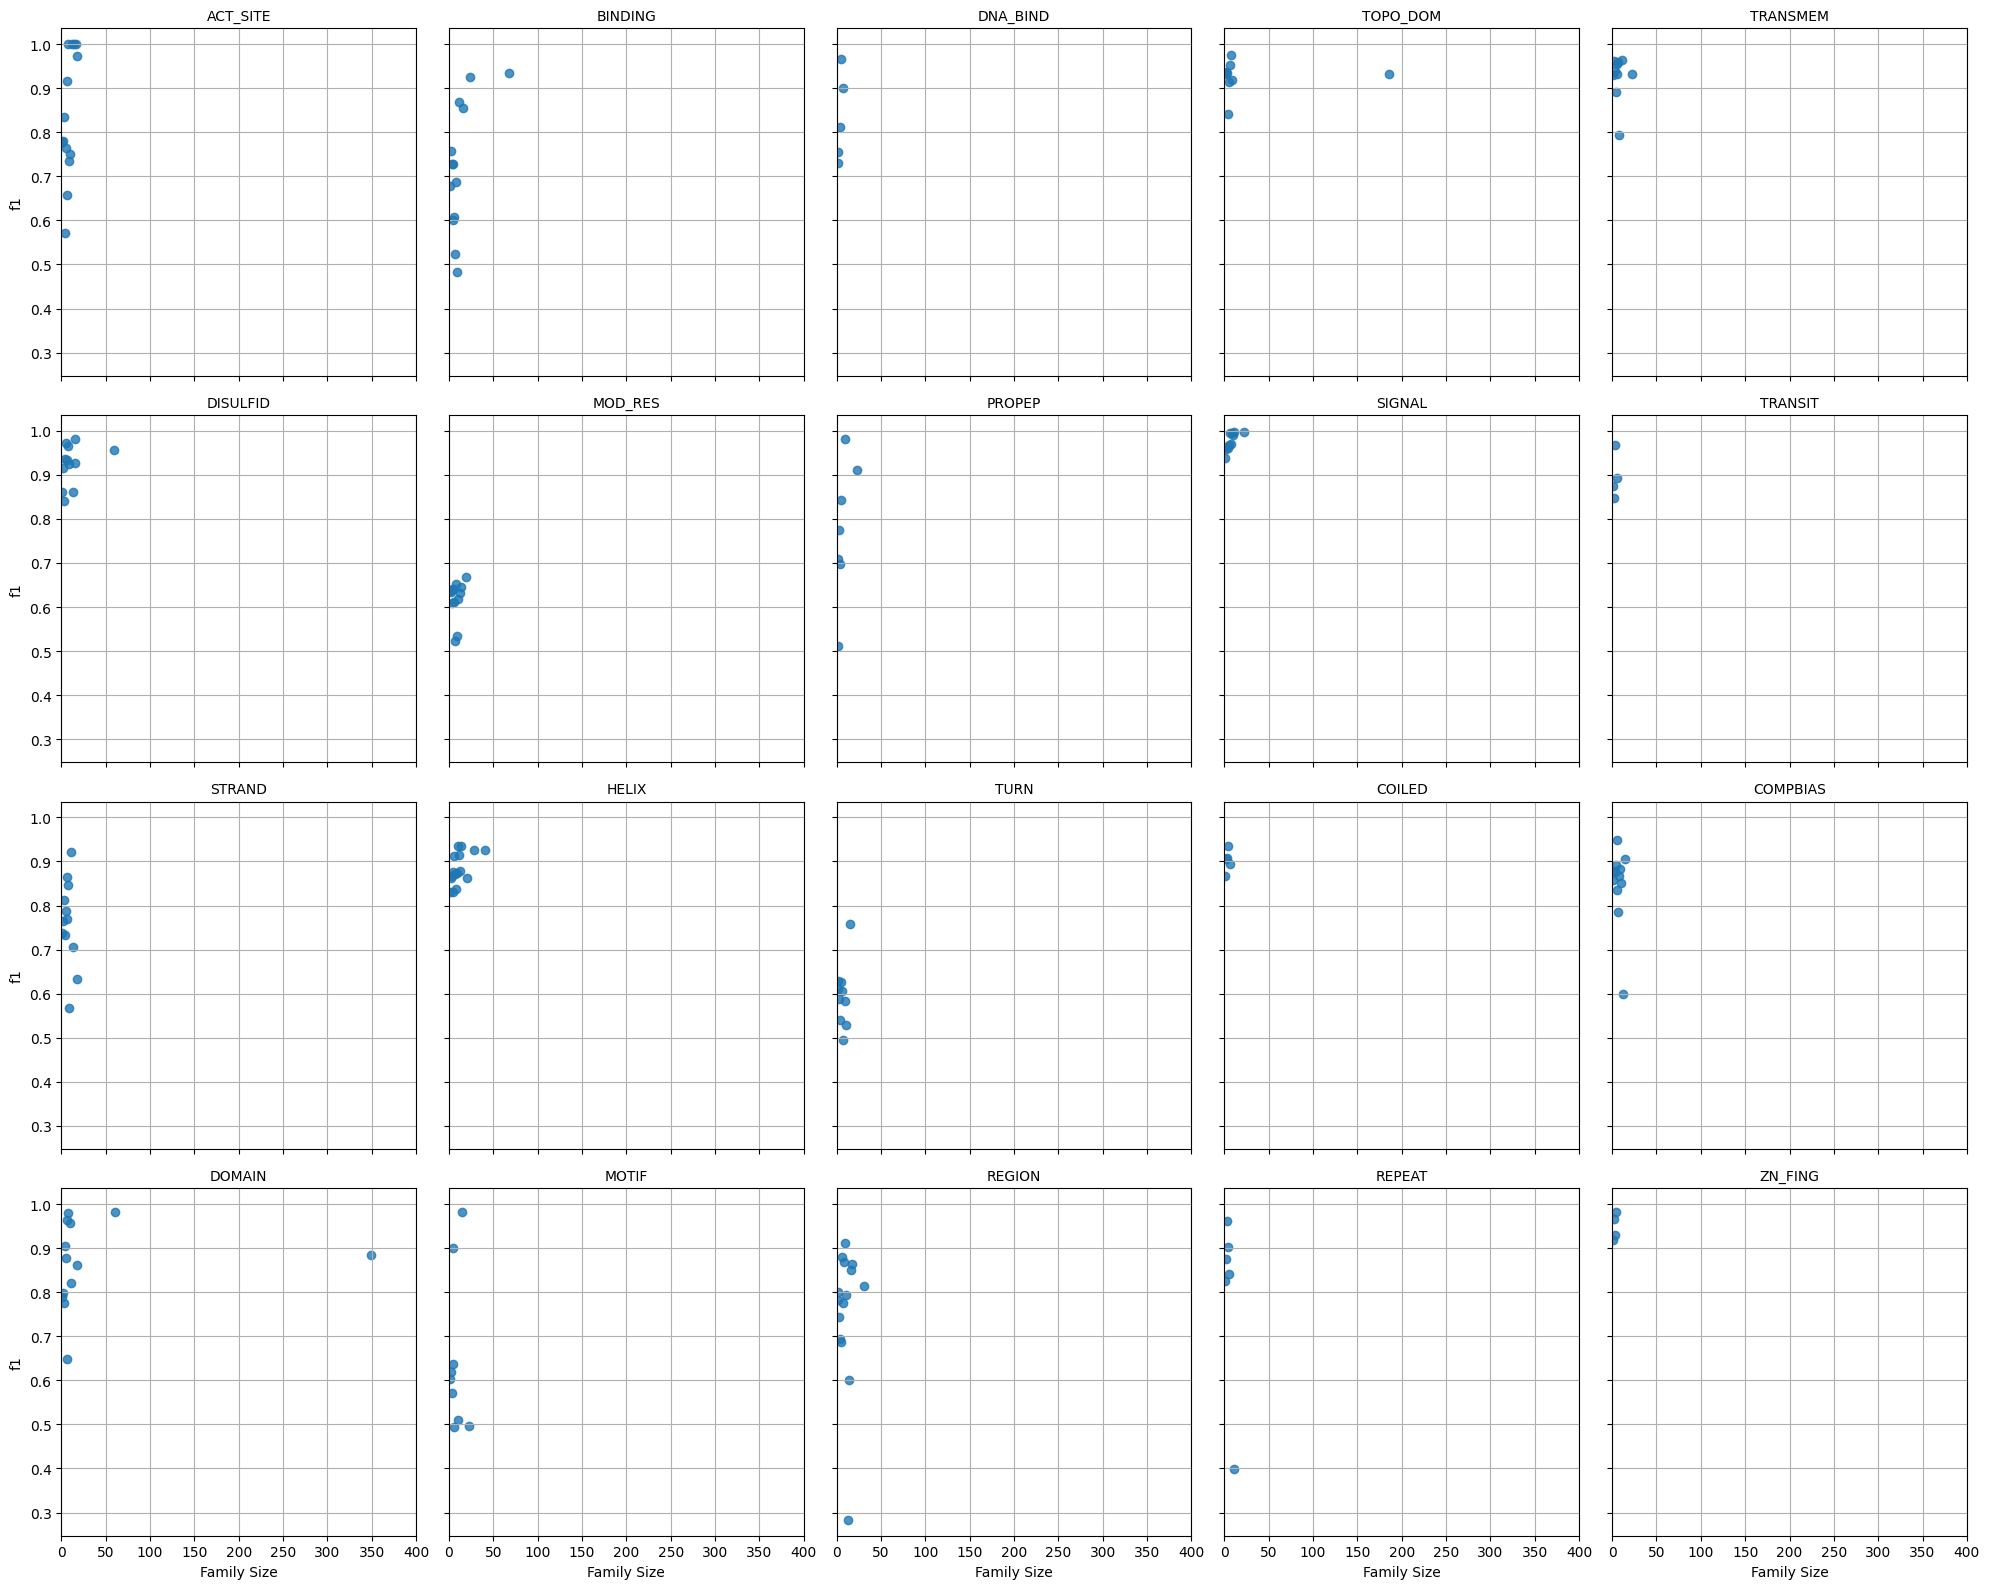

In [56]:
plot_feature_metric_grid(
    metrics_dir="../res/metrics_per_family",
    metric="f1",
    max_size=400,
    save=True,
    save_path="../res/figures/f1_vs_family_size_400.png"
)
